In [310]:
!pip install seaborn==0.11.0

# Milestone 3: Predicting the Presidential and House of Representative Elections
#### Estelle Yao, Noah Ramos, Saul Holding, Ivan Shu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
from time import sleep

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeCV

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 1500)

import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# EDA

In [72]:
# NOTE: We plan test our base model on three different predictors and for each party. All is made clear in the accompanying document
# Reading in the data
# data_train = pd.read_csv('train_test_data/train_updated2.csv')
# test_df = pd.read_csv('train_test_data/testing_set.csv')

data_train = pd.read_csv('train_test_data/train_updated3.csv')

# Changing data types to floats
data_train['Poverty Estimate, All Ages']=data_train['Poverty Estimate, All Ages'].astype(float)
data_train['Poverty Percent, All Ages']=data_train['Poverty Percent, All Ages'].astype(float)
data_train['Poverty Estimate, Age 0-17']=data_train['Poverty Estimate, Age 0-17'].astype(float)
data_train['Poverty Percent, Age 0-17']=data_train['Poverty Percent, Age 0-17'].astype(float)
data_train['Poverty Estimate, Age 5-17 in Families']=data_train['Poverty Estimate, Age 5-17 in Families'].astype(float)
data_train['Poverty Percent, Age 5-17 in Families']=data_train['Poverty Percent, Age 5-17 in Families'].astype(float)
data_train['Median Household Income']=data_train['Median Household Income'].astype(float)
data_train['Poverty Estimate, All Ages']=data_train['Poverty Estimate, All Ages'].astype(float)

###Added variables: lag response = percentage voted for democrats/republicans in 2012/percentage voted for democrats in 2008 
data_train['lag_response_dem']=data_train['Democrats 2012']/data_train['Democrats 2008']
data_train['lag_response_rep']=data_train['Republicans 2012']/data_train['Republicans 2008']

##Outcome variables: percentage of votes weighted by county population
data_train['response_rep']=data_train['TOT_POP']*data_train['Republicans 2016']
data_train['response_dem']=data_train['TOT_POP']*data_train['Democrats 2016']

# Adding in the different responses
data_train['log_response_dem'] = np.log(data_train['response_dem'])
data_train['log_response_rep'] = np.log(data_train['response_rep'])

# Converting number of advanced ballots to percentage
data_train['bal2016/popu2016'] = data_train['calculated approx. county adv. Ballots 2016'] / data_train['2016 Population']

# Recalculate 
data_train['perc_adv'] = data_train['calculated approx. county adv. Ballots 2016'] / data_train['2016 Population']

display(data_train.describe())
print(data_train.shape)

Unnamed: 0          FIPS    Precincts         Votes  Democrats 08 (Votes)  Democrats 12 (Votes)  Republicans 08 (Votes)  Republicans 12 (Votes)  Republicans 2016  Democrats 2016   Green 2016  Libertarians 2016  Republicans 2012  Republicans 2008  Democrats 2012  Democrats 2008  SUMLEV    YEAR  AGEGRP       TOT_POP      TOT_MALE    TOT_FEMALE       WA_MALE     WA_FEMALE        BA_MALE      BA_FEMALE       IA_MALE     IA_FEMALE        AA_MALE      AA_FEMALE       NA_MALE     NA_FEMALE       TOM_MALE     TOM_FEMALE      WAC_MALE    WAC_FEMALE       BAC_MALE     BAC_FEMALE       IAC_MALE     IAC_FEMALE       AAC_MALE     AAC_FEMALE       NAC_MALE     NAC_FEMALE       NH_MALE     NH_FEMALE     NHWA_MALE   NHWA_FEMALE      NHBA_MALE    NHBA_FEMALE     NHIA_MALE   NHIA_FEMALE      NHAA_MALE    NHAA_FEMALE     NHNA_MALE   NHNA_FEMALE     NHTOM_MALE   NHTOM_FEMALE    NHWAC_MALE  NHWAC_FEMALE     NHBAC_MALE   NHBAC_FEMALE    NHIAC_MALE  NHIAC_FEMALE     NHAAC_MALE   NHAAC_FEMALE     NHNAC_MALE   NHNAC_FEMALE        H_MALE      H_FEMALE      HWA_MALE    HWA_FEMALE      HBA_MALE     HBA_FEMALE      HIA_MALE    HIA_FEMALE      HAA_MALE    HAA_FEMALE     HNA_MALE   HNA_FEMALE     HTOM_MALE   HTOM_FEMALE     HWAC_MALE   HWAC_FEMALE      HBAC_MALE    HBAC_FEMALE     HIAC_MALE   HIAC_FEMALE     HAAC_MALE   HAAC_FEMALE     HNAC_MALE   HNAC_FEMALE        FIPS.1  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  School Enrollment  Civilian_labor_force_2016  \
count  3139.000000   3139.000000  3111.000000  3.111000e+03          3.111000e+03          3.111000e+03             3111.000000             3111.000000       3111.000000     3111.000000  2601.000000        3111.000000       3111.000000       3111.000000     3111.000000     3111.000000  3139.0  3139.0  3139.0  3.139000e+03  3.139000e+03  3.139000e+03  3.139000e+03  3.139000e+03    3139.000000    3139.000000   3139.000000   3139.000000    3139.000000    3139.000000   3139.000000   3139.000000    3139.000000    3139.000000  3.139000e+03  3.139000e+03    3139.000000    3139.000000    3139.000000    3139.000000    3139.000000    3139.000000    3139.000000    3139.000000  3.139000e+03  3.139000e+03  3.139000e+03  3.139000e+03    3139.000000    3139.000000   3139.000000   3139.000000    3139.000000    3139.000000   3139.000000   3139.000000    3139.000000    3139.000000  3.139000e+03  3.139000e+03    3139.000000    3139.000000   3139.000000   3139.000000    3139.000000    3139.000000    3139.000000    3139.000000  3.139000e+03  3.139000e+03  3.139000e+03  3.139000e+03   3139.000000    3139.000000   3139.000000   3139.000000   3139.000000   3139.000000  3139.000000  3139.000000   3139.000000   3139.000000  3.139000e+03  3.139000e+03    3139.000000    3139.000000   3139.000000   3139.000000   3139.000000   3139.000000   3139.000000   3139.000000   3139.000000                   3139.000000                  3139.000000      3139.000000        3139.000000               3.139000e+03   
mean   1569.000000  30392.532972    54.927997  4.176518e+04          2.229861e+04          2.114430e+04            19207.495018            19532.239151         63.608655       31.679286     0.874781           3.163017         59.670636         56.812707       38.481760       41.540440    50.0     9.0     0.0  1.028731e+05  5.065636e+04  5.221673e+04  3.922311e+04  3.991419e+04    6554.200064    7134.899968    648.019114    637.028990    2776.347244    3047.128703    123.808538    120.142721    1330.874482    1363.334820  4.040511e+04  4.111825e+04    7138.959860    7749.088245    1059.376234    1069.166932    3268.624403    3540.416693     243.977063     242.008601  4.140983e+04  4.316121e+04  3.107626e+04  3.195168e+04    6126.071360    6690.502071    371.693214    382.786238    2686.350112    2956.609430     90.769990     89.423065    1058.681109    1090.208028  3.201576e+04  3.291324e+04    6587.396942    7177.934055    666.381650    698.860465    3103.460019    3374.394075     185.130615     1

(3139, 198)


In [73]:
####Divide demographic data by total population in the county so each variable would not correlate with population size
demo=data_train.iloc[:, data_train.columns.get_loc('TOT_MALE'):data_train.columns.get_loc('NA_FEMALE')+1]
temp=pd.DataFrame()
for col in demo.columns:
    temp[col]=data_train[col]/data_train['TOT_POP']*100
data_train.iloc[:, data_train.columns.get_loc('TOT_MALE'):data_train.columns.get_loc('NA_FEMALE')+1]=temp

demo=data_train.iloc[:, data_train.columns.get_loc('Civilian_labor_force_2016'):data_train.columns.get_loc('Unemployed_2016')+1]
temp=pd.DataFrame()
for col in demo.columns:
    temp[col]=data_train[col]/data_train['TOT_POP']*100
data_train.iloc[:, data_train.columns.get_loc('Civilian_labor_force_2016'):data_train.columns.get_loc('Unemployed_2016')+1]=temp

data_train.loc[:, 'Poverty Estimate, All Ages']=data_train.loc[:, 'Poverty Estimate, All Ages']/data_train['TOT_POP']*100

demo=data_train.iloc[:, data_train.columns.get_loc('NUI'):data_train.columns.get_loc('NIC')+1]
temo=pd.DataFrame()
for col in demo.columns:
    temp[col]=data_train[col]/data_train['TOT_POP']*100
data_train.iloc[:, data_train.columns.get_loc('NUI'):data_train.columns.get_loc('NIC')+1]=temp


In [33]:
business=data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1]
b_tot=business.sum(axis=1)

temp=pd.DataFrame()
for col in business.columns:
    temp[col]=data_train[col]/b_tot*100

temp=temp.fillna(0) 

data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1]=temp

In [34]:
data_train.head()

Unnamed: 0    State  ST  FIPS            County  Precincts    Votes  Democrats 08 (Votes)  Democrats 12 (Votes)  Republicans 08 (Votes)  Republicans 12 (Votes)  Republicans 2016  Democrats 2016  Green 2016  Libertarians 2016  Republicans 2012  Republicans 2008  Democrats 2012  Democrats 2008  SUMLEV  YEAR  AGEGRP  TOT_POP   TOT_MALE  TOT_FEMALE    WA_MALE  WA_FEMALE    BA_MALE  BA_FEMALE   IA_MALE  IA_FEMALE   AA_MALE  AA_FEMALE   NA_MALE  NA_FEMALE  TOM_MALE  TOM_FEMALE  WAC_MALE  WAC_FEMALE  BAC_MALE  BAC_FEMALE  IAC_MALE  IAC_FEMALE  AAC_MALE  AAC_FEMALE  NAC_MALE  NAC_FEMALE  NH_MALE  NH_FEMALE  NHWA_MALE  NHWA_FEMALE  NHBA_MALE  NHBA_FEMALE  NHIA_MALE  NHIA_FEMALE  NHAA_MALE  NHAA_FEMALE  NHNA_MALE  NHNA_FEMALE  NHTOM_MALE  NHTOM_FEMALE  NHWAC_MALE  NHWAC_FEMALE  NHBAC_MALE  NHBAC_FEMALE  NHIAC_MALE  NHIAC_FEMALE  NHAAC_MALE  NHAAC_FEMALE  NHNAC_MALE  NHNAC_FEMALE  H_MALE  H_FEMALE  HWA_MALE  HWA_FEMALE  HBA_MALE  HBA_FEMALE  HIA_MALE  HIA_FEMALE  HAA_MALE  HAA_FEMALE  HNA_MALE  HNA_FEMALE  HTOM_MALE  HTOM_FEMALE  HWAC_MALE  HWAC_FEMALE  HBAC_MALE  HBAC_FEMALE  HIAC_MALE  HIAC_FEMALE  HAAC_MALE  HAAC_FEMALE  HNAC_MALE  HNAC_FEMALE  FIPS.1  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  School Enrollment  Civilian_labor_force_2016  Employed_2016  Unemployed_2016  Unemployment_rate_2016 Postal Code  Poverty Estimate, All Ages  Poverty Percent, All Ages  Poverty Estimate, Age 0-17  Poverty Percent, Age 0-17  \
0           0  Alabama  AL  1005    Barbour County       18.0  10390.0                5697.0                5912.0                  5866.0                  5550.0         52.271415       46.660250    0.173244           0.895091         48.189633         50.438521       51.332812       48.985383      50     9       0    25806  52.801674   47.198326  26.269085  23.525537  25.246067  22.700147  0.352631   0.232504  0.209254   0.224754  0.108502   0.050376       159         120      6897        6176      6622        5929       168         107        69          78        33          18    13004      11689       6272         5665       6473         5811         40           33         54           58         16            6         149           116        6383          5766        6573          5881         111            78          69            77          21            11     622       491       507         406        42          47        51          27         0           0        12           7         10            4        514          410         49           48         57           29          0            1         12            7    1005                          71.9                         13.5              6.0              67.85                  32.690072      29.977525         2.712547                0.032163          AL                   26.300085                       29.9                      2146.0                       39.6   
1           1  Alabama  AL  1113    Russell County       19.0  19136.0               10085.0               10500.0                  8705.0                  8278.0         48.129181       50.047032    0.355351           1.468436         43.775780         46.021676       55.526177       53.317473      50     9       0    58185  48.387041   51.612959  25.207528  25.781559  21.261494  23.669331  0.287016   0.264673  0.290453   0.544814  0.132337   0.142648       703         704     15281       15616     12772       14167       407         404       344         494       121         128    26541      28532      13527        13932      12084        13491        120          111        143          297         68           73         599           628       14050         14483       12424         13849         311           320         297           456          98           109    1613      1499      1140        1069       287         281        47          43        26          20         9          10        104           76       1231         1133       

## EDA on Response Variables

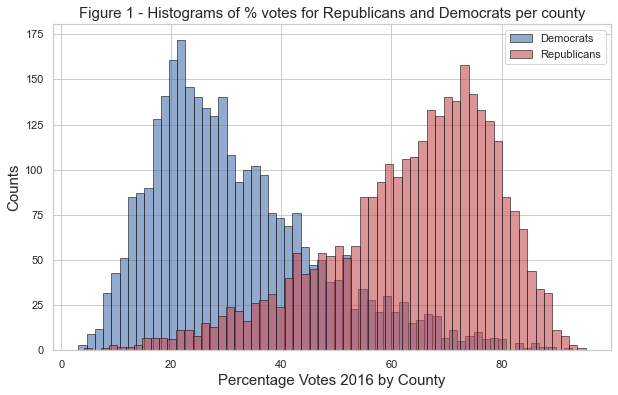

In [35]:
# Intializing plot
plt.figure(figsize=(10,6))

# Plotting histograms 
plt.hist(data_train['Democrats 2016'], bins=60, edgecolor='k', alpha=0.6, 
        color='b', label='Democrats')
plt.hist(data_train['Republicans 2016'], bins=60, edgecolor='k', alpha=0.6, 
         color='r', label='Republicans')

# Setting labels
plt.xlabel('Percentage Votes 2016 by County', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Figure 1 - Histograms of % votes for Republicans and Democrats per county', fontsize=15)

# Setting legend
plt.legend()

plt.show()

Figure 1 - Histograms of % votes for Republicans and Democrats per county

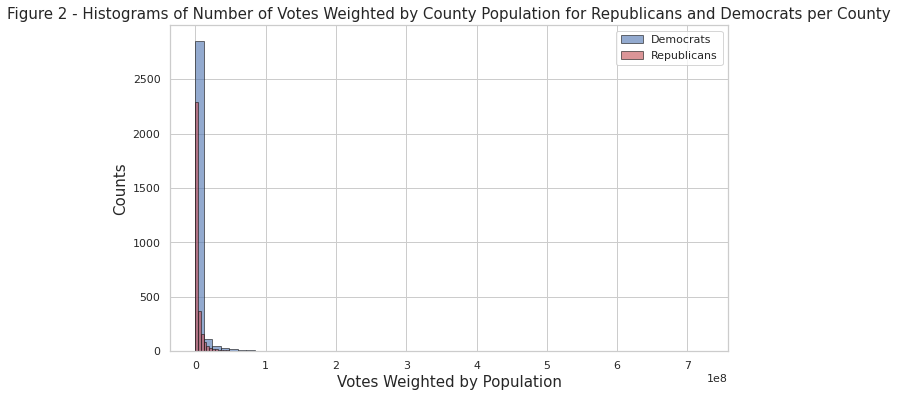

In [315]:
# Initialzing plot
plt.figure(figsize=(10,6))

# Plotting histogram
plt.hist(data_train['response_dem'], bins=60, edgecolor='k', alpha=0.6, 
        color='b', label='Democrats')
plt.hist(data_train['response_rep'], bins=60, edgecolor='k', alpha=0.6, 
         color='r', label='Republicans')

# Setting labels
plt.xlabel('Votes Weighted by Population', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Figure 2 - Histograms of Number of Votes Weighted by County Population for Republicans and Democrats per County', fontsize=15)

# Setting legend
plt.legend()
plt.show()

Figure 2 - Histograms of Number of Votes Weighted by County Population for Republicans and Democrats per County

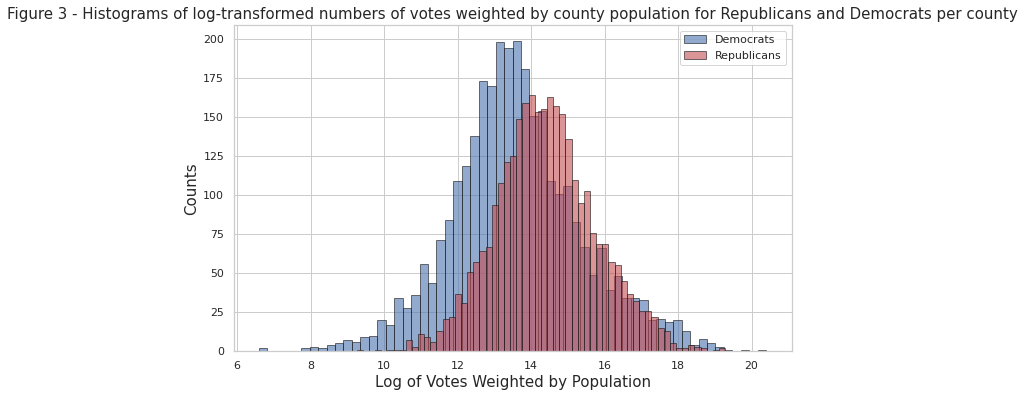

In [316]:
# Initialzing plot
plt.figure(figsize=(10,6))

# Plotting histogram
plt.hist(data_train['log_response_dem'], bins=60, edgecolor='k', alpha=0.6, 
        color='b', label='Democrats')
plt.hist(data_train['log_response_rep'], bins=60, edgecolor='k', alpha=0.6, 
         color='r', label='Republicans')

# Setting labels
plt.xlabel('Log of Votes Weighted by Population', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Figure 3 - Histograms of log-transformed numbers of votes weighted by county population for Republicans and Democrats per county', fontsize=15)

# Setting legend
plt.legend()
plt.show()

Figure 3 - Histograms of log-transformed numbers of votes weighted by county population for Republicans and Democrats per county

## Voting Consistency

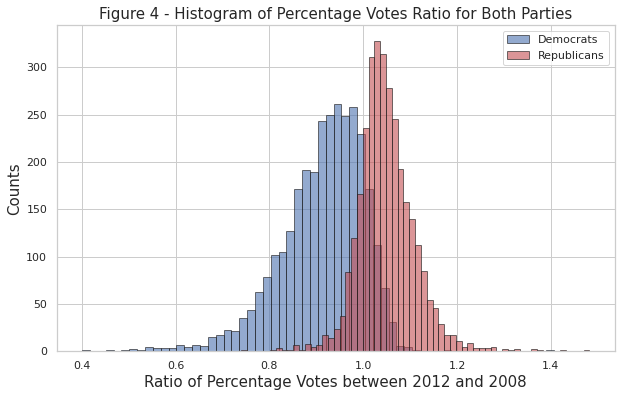

In [317]:
# Now, we are dealing with both 'lag_response_dem' and 'lag_response_rep' variables.
# Figure 3 - Histogram of Percentage Votes Ratio between 2012 and 2008 for Both Parties
# Initialzing plot
plt.figure(figsize=(10,6))

# Plotting histogram
plt.hist(data_train.lag_response_dem, bins=60, edgecolor='k', alpha=0.6, 
        color='b', label='Democrats')
plt.hist(data_train.lag_response_rep, bins=60, edgecolor='k', alpha=0.6, 
         color='r', label='Republicans')

# Setting labels
plt.xlabel('Ratio of Percentage Votes between 2012 and 2008', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Figure 4 - Histogram of Percentage Votes Ratio for Both Parties', fontsize=15)

# Setting legend
plt.legend()
plt.show()

Figure 4 - Histogram of Percentage Votes Ratio for Both Parties

In [318]:
# This suggests that majorities of counties are shifting their voting habits 
# And they are moving to vote more for republicans
# in 2016. This makes sense as Trump won the election.

## EDA on Demographic and Business Data

In [40]:
# I will use train_merge.columns a bit later
# to get the column names of this
demographic_business=pd.concat([data_train.iloc[:, data_train.columns.get_loc('TOT_MALE'):data_train.columns.get_loc('NA_FEMALE')+1],
                       data_train.iloc[:, data_train.columns.get_loc('At Least High School Diploma'):data_train.columns.get_loc('School Enrollment')+1],
                       data_train.loc[:, 'Poverty Estimate, All Ages'],
                       data_train.loc[:, 'Median Household Income'],
                       data_train.iloc[:, data_train.columns.get_loc('NUI'):data_train.columns.get_loc('NIC')+1],
                       data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1]], axis=1)

In [41]:
# Shape
print(f"The shape is: {demographic_business.shape}")

The shape is: (3139, 40)


In [42]:
# Defining correlation variable
demographic_business_cor=demographic_business.corr(method="pearson")

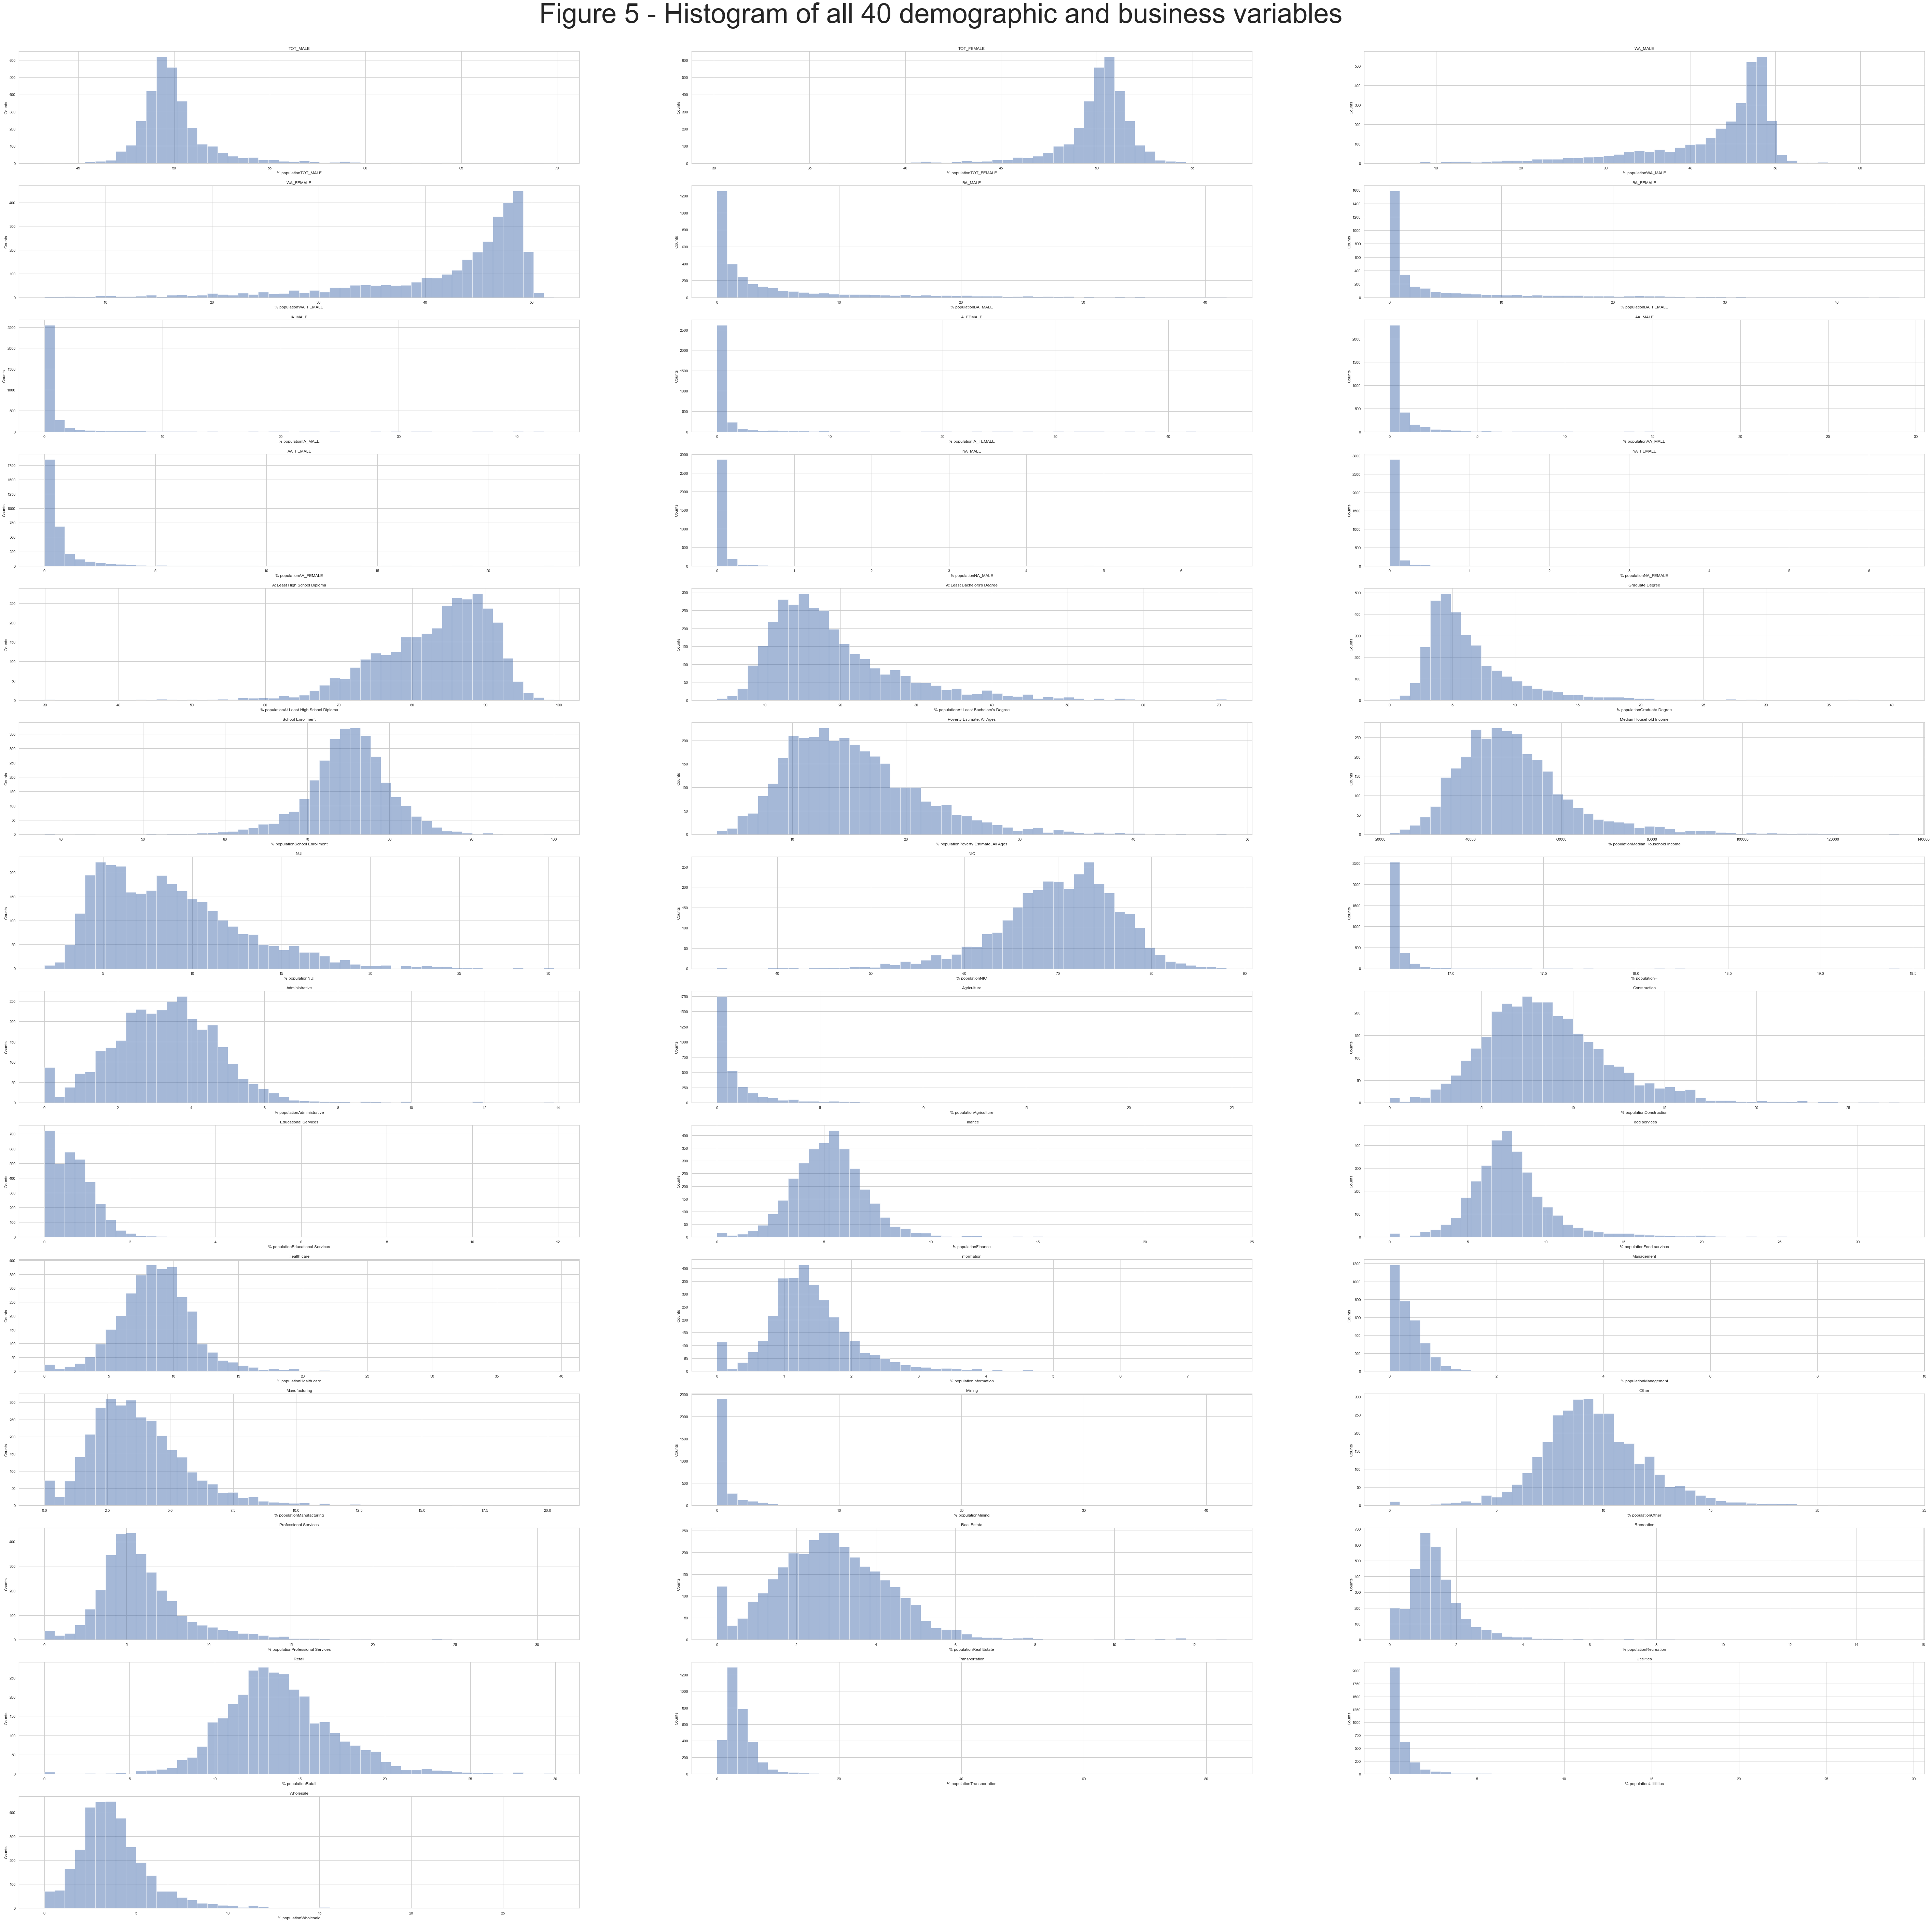

In [44]:
# Plotting percentage of votes against Business predictors and Demographic data
plt.figure(figsize=[100,100])

for i, col in enumerate(demographic_business.columns):
    plt.subplot(14, 3, i+1)
    plt.hist(x=( (demographic_business[col])), bins=50, alpha=0.5)
    plt.ylabel('Counts')
    plt.xlabel('% population' + col)
    plt.title(col)

plt.suptitle("Figure 5 - Histogram of all 40 demographic and business variables", y = .90, fontsize=80)
plt.show()

Figure 5 - Histogram of all 40 demographic and business variables

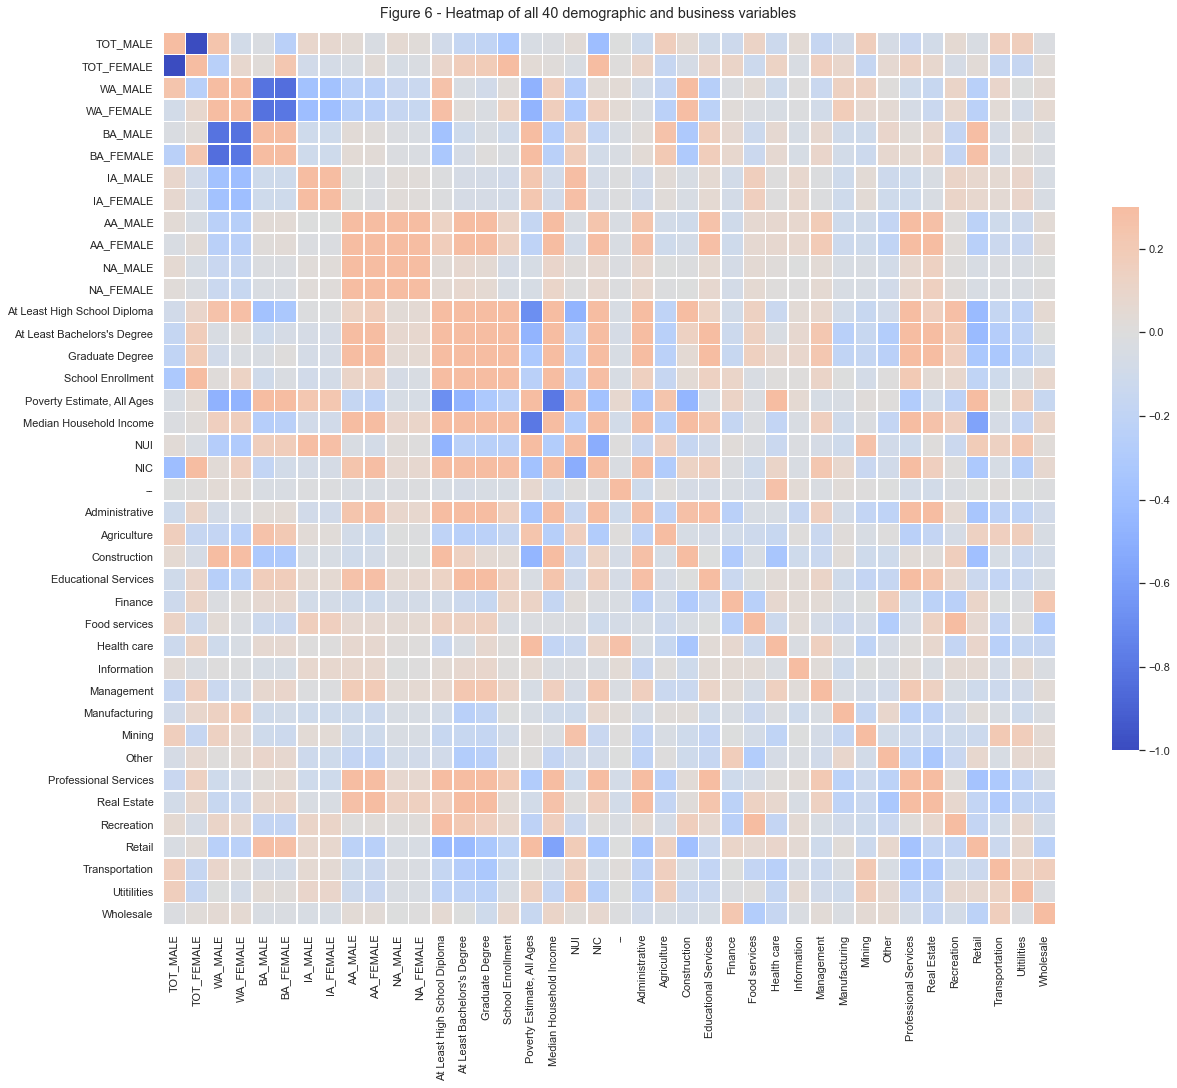

In [46]:
# Plotting a correlation heat map with demographic data dand business data
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(demographic_business_cor, cmap="coolwarm",vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.suptitle("Figure 6 - Heatmap of all 40 demographic and business variables", x=.42, y=.83)
plt.show()

There is not much correlation among variables thus less concern for problems of collinearity  

Figure 6 - Heatmap of all 41 demographic and business variables

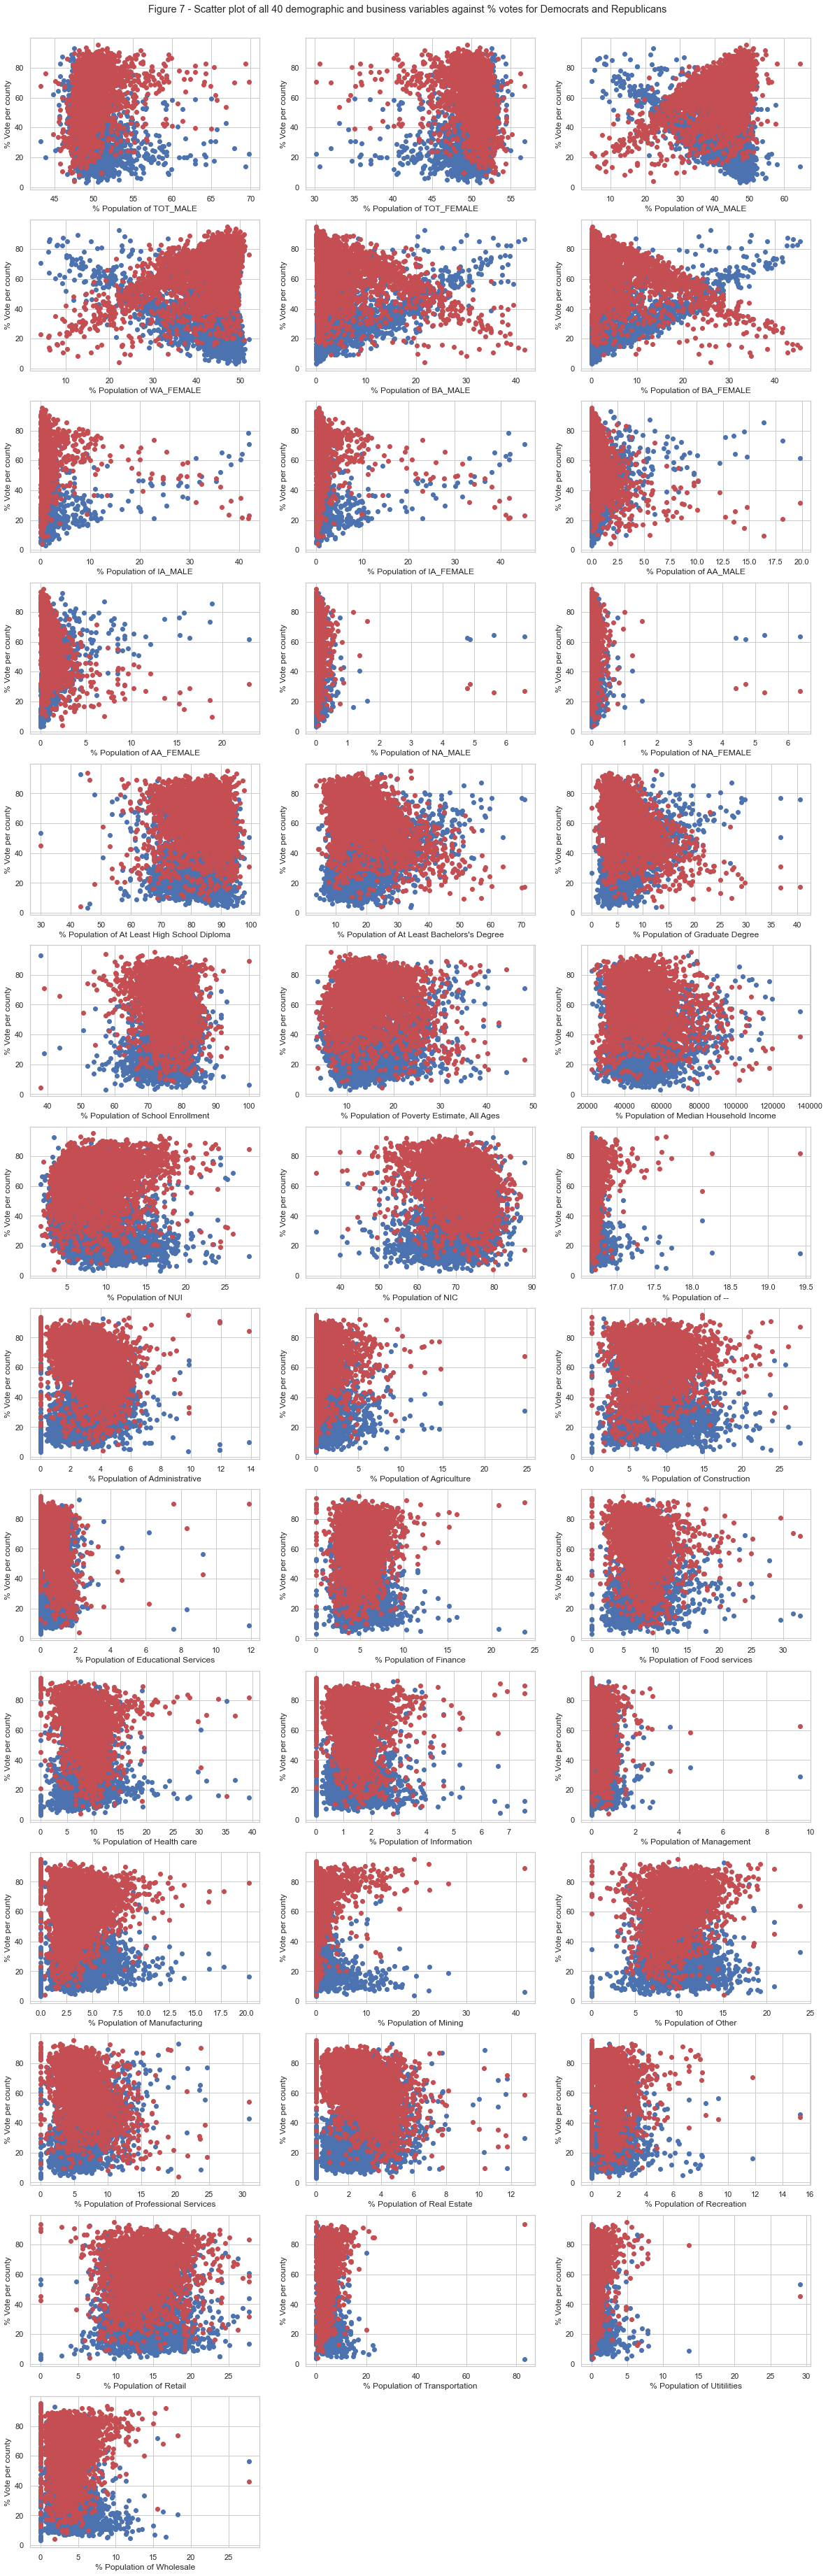

In [50]:
###Regression to election outcome 2016 
plt.figure(figsize=[20,66])

for i, col in enumerate(demographic_business.columns):
    plt.subplot(14, 3, i+1)
    plt.scatter(y=data_train['Democrats 2016'], x=(demographic_business[col]) ,color='b')
    plt.scatter(y=data_train['Republicans 2016'], x=(demographic_business[col]),color='r' )
    plt.xlabel('% Population of ' + col)
    plt.ylabel('% Vote per county')

plt.suptitle("Figure 7 - Scatter plot of all 40 demographic and business variables against % votes for Democrats and Republicans", y = .89)
plt.show()

Figure 7 - Scatter plot of all 41 demographic and business variables against % votes for Democrats and Republicans

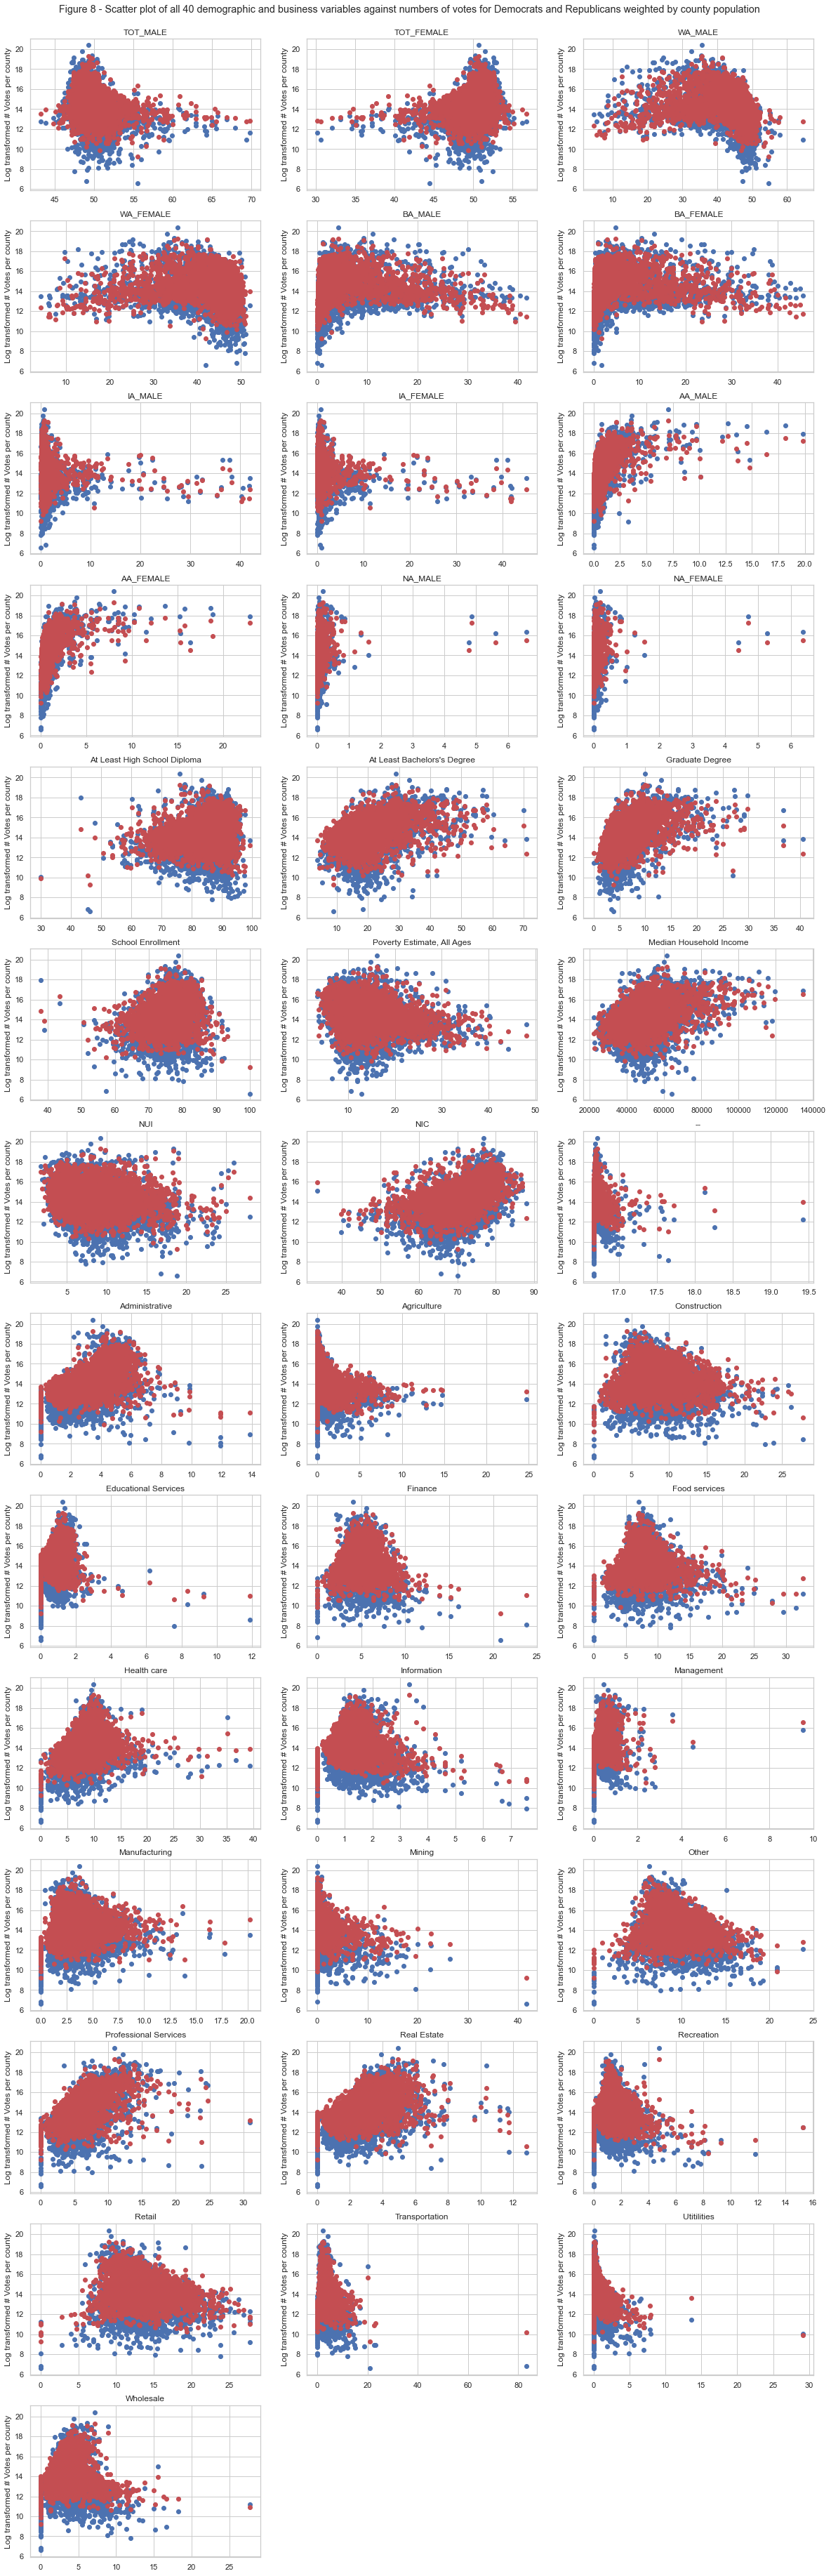

In [52]:
###correlation with # votes 

plt.figure(figsize=[20,66])

for i, col in enumerate(demographic_business.columns):
    plt.subplot(14, 3, i+1)
    plt.scatter(y=np.log(data_train['response_dem']), x=(demographic_business[col]) ,color='b')
    plt.scatter(y=np.log(data_train['response_rep']), x=(demographic_business[col]),color='r' )
    plt.ylabel('Log transformed # Votes per county')
    plt.title(col)

plt.suptitle("Figure 8 - Scatter plot of all 40 demographic and business variables against numbers of votes for Democrats and Republicans weighted by county population", y=.89)

plt.show()

Figure 8 - Scatter plot of all 41 demographic and business variables against numbers of votes for Democrats and Republicans weighted by county population

## EDA on House of Representatives Financial Data

In [326]:
 ## Note: We will analyze these variable on all three response variable we plan to use

In [89]:
# Finance
finance=data_train.iloc[:, data_train.columns.get_loc('house_rep_receipts'):data_train.columns.get_loc('house_dem_cash_on_hand')+1]
finance.shape


(3139, 6)

In [90]:
# Describing the data
finance.describe()

house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand
count        3.139000e+03        3.139000e+03            3.139000e+03        3.139000e+03        3.139000e+03            3.139000e+03
mean         1.576236e+07        1.493184e+07            4.196804e+06        9.709655e+06        8.698864e+06            2.700840e+06
std          1.352539e+07        1.308636e+07            4.149659e+06        1.414240e+07        1.268135e+07            4.299082e+06
min          0.000000e+00        0.000000e+00           -3.896720e+03        3.766634e+04        2.882283e+04            0.000000e+00
25%          6.117663e+06        6.041473e+06            1.070736e+06        1.438342e+06        1.248608e+06            3.838517e+05
50%          1.384217e+07        1.295522e+07            2.794079e+06        4.405427e+06        3.979693e+06            9.883107e+05
75%          1.961964e+07        1.822542e+07            5.245551e+06        1.379829e+07        1.018831e+07            3.211977e+06
max          4.726561e+07        4.822634e+07            1.391429e+07        8.116243e+07        7.071228e+07            2.616824e+07

In [91]:
# Dipslaying the info
finance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   house_rep_receipts      3139 non-null   float64
 1   house_rep_disburse      3139 non-null   float64
 2   house_rep_cash_on_hand  3139 non-null   float64
 3   house_dem_receipts      3139 non-null   float64
 4   house_dem_disburse      3139 non-null   float64
 5   house_dem_cash_on_hand  3139 non-null   float64
dtypes: float64(6)
memory usage: 147.3 KB


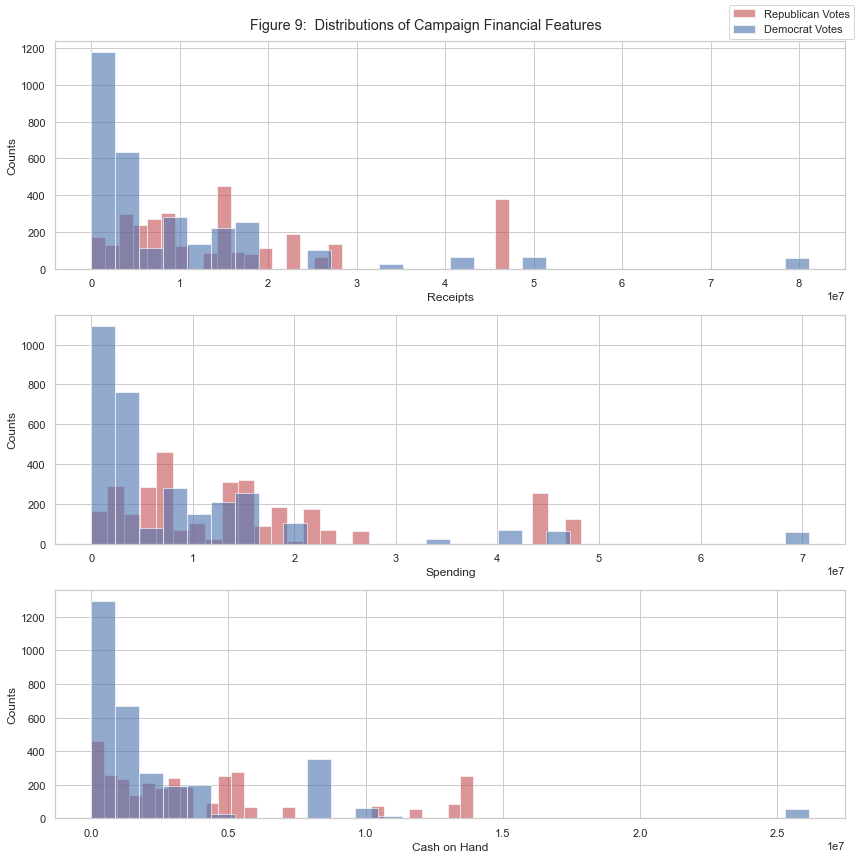

In [92]:
# Setting lists
dem_finance = ['house_dem_receipts', 'house_dem_disburse', 'house_dem_cash_on_hand']
rep_finance = ['house_rep_receipts', 'house_rep_disburse', 'house_rep_cash_on_hand']
names_finance = ['Receipts', "Spending", 'Cash on Hand']

# Initializing the subplots
fig, ax  = plt.subplots(nrows= 3, figsize=(12,12))

# Setting counters
r = 0

# Plotting
for rep, dem, n in zip(rep_finance, dem_finance, names_finance):
    if rep == 'house_rep_receipts' and dem == 'house_dem_receipts':
        ax[r].hist(data_train[rep], bins = 30, color = 'r', alpha = .6, label = 'Republican Votes')
        ax[r].hist(data_train[dem], bins = 30, color = 'b', alpha = .6, label = 'Democrat Votes')
        ax[r].set_xlabel(n)
        ax[r].set_ylabel('Counts')
        r+=1
    else:
        ax[r].hist(data_train[rep], bins = 30, color = 'r', alpha = .6)
        ax[r].hist(data_train[dem], bins = 30, color = 'b', alpha = .6)
        ax[r].set_xlabel(n)
        ax[r].set_ylabel('Counts')
        r+=1

# Setting legend
fig.legend(loc='upper right')

# Setting the super title
fig.suptitle("Figure 9:  Distributions of Campaign Financial Features")

# Making the layout tighter
fig.tight_layout()

plt.show()


Figure 9:  Distributions of Campaign Financial Features

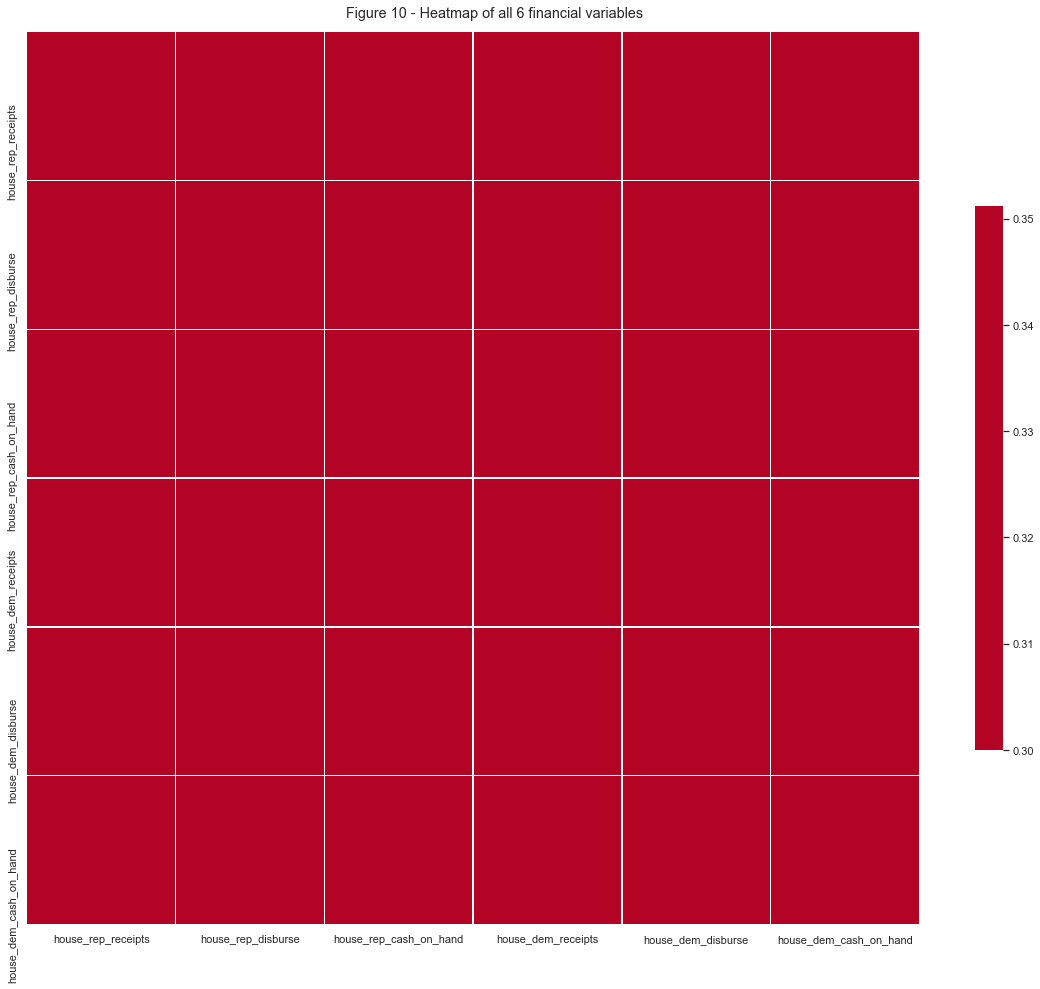

In [93]:
# Correlation variable
train_finance_cor=finance.corr(method="pearson")

# Heatmap for chosen variables
f, ax = plt.subplots(figsize=(20, 20))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(train_finance_cor, cmap="coolwarm", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.suptitle("Figure 10 - Heatmap of all 6 financial variables", x=.45, y=.83)
plt.show()

Figure 10 - Heatmap of all 6 financial variables

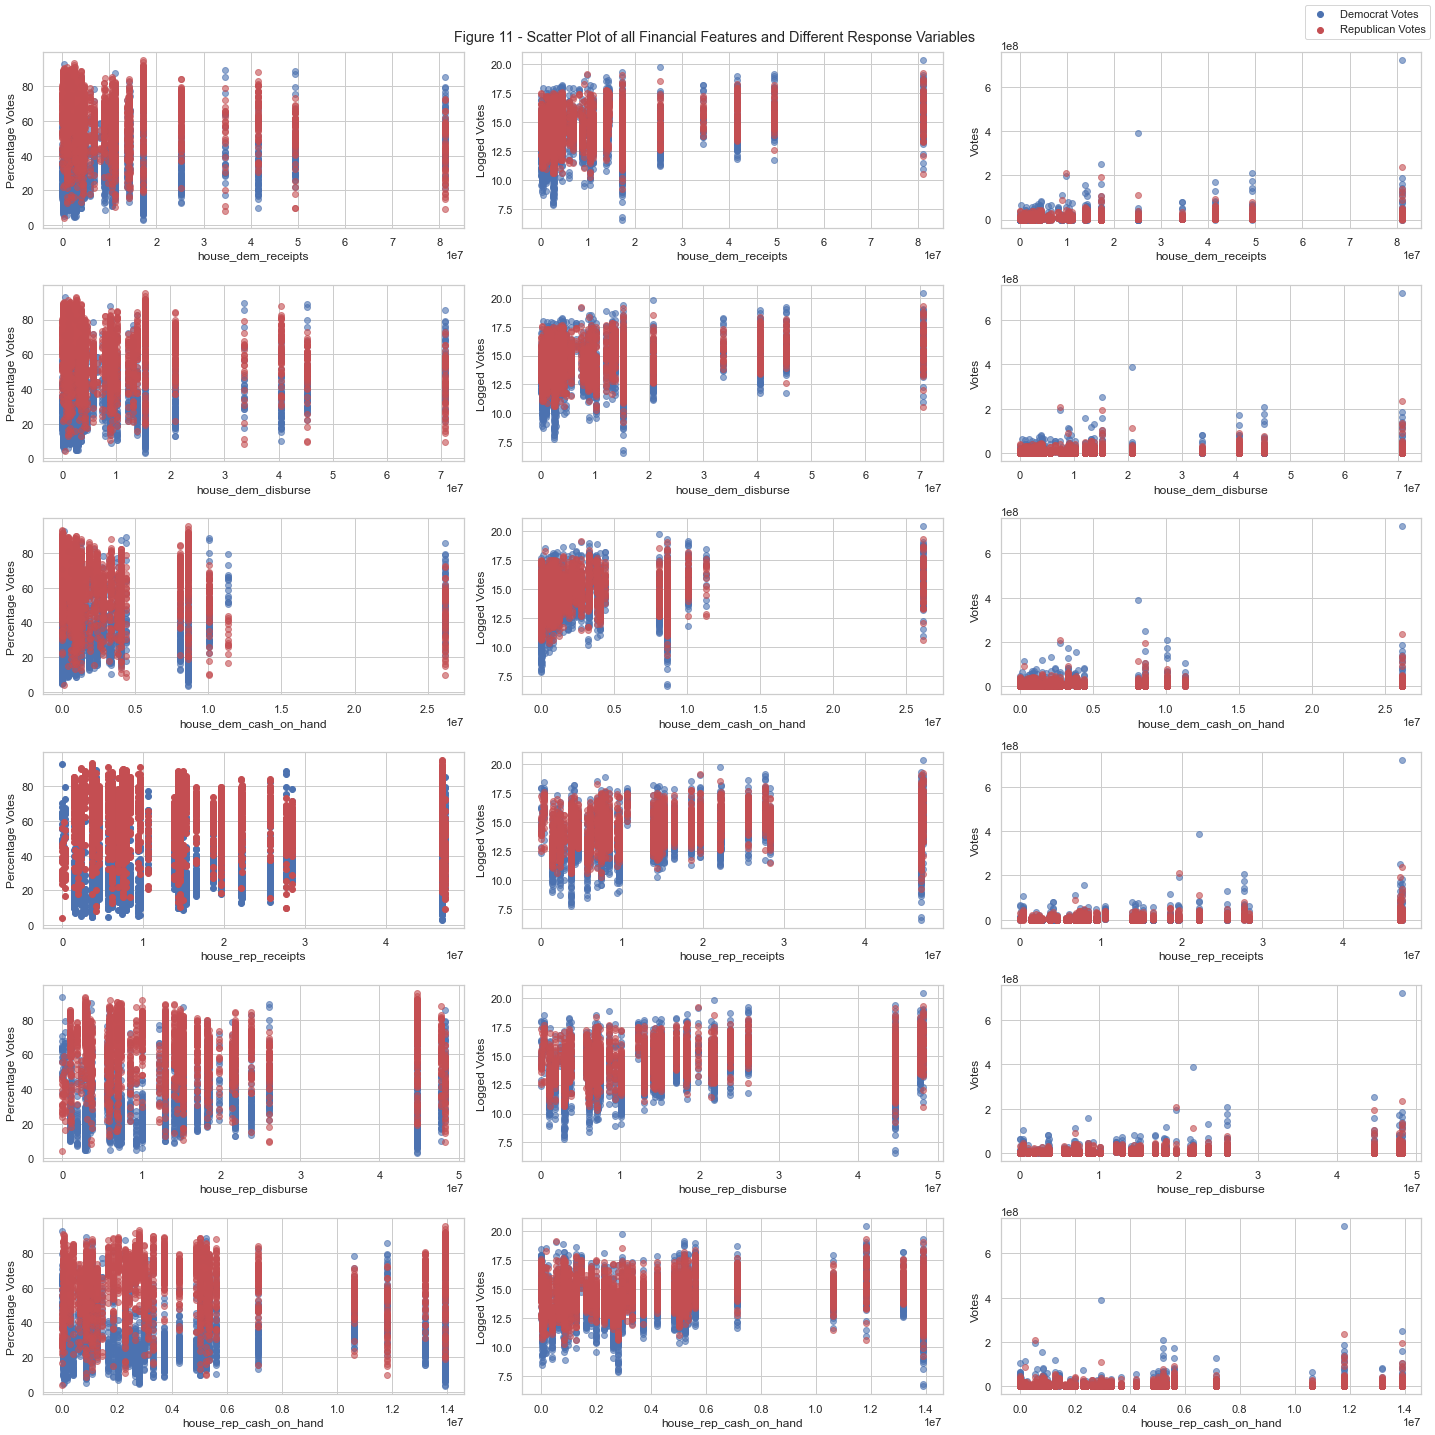

In [94]:
# Setting lists needed for the plotting
finance_list = ['house_dem_receipts', 'house_dem_disburse', 'house_dem_cash_on_hand', 'house_rep_receipts', 'house_rep_disburse', 'house_rep_cash_on_hand']
y_dem = ['Democrats 2016', 'log_response_dem', 'response_dem']
y_rep = ['Republicans 2016', 'log_response_rep', 'response_rep']
names_response = ['Percentage Votes', 'Logged Votes', 'Votes']


# Intializing the subplots
fig, ax  = plt.subplots(nrows= 6, ncols=3, figsize=(20,20))

# Setting counters
r = 0
c = 0 

# Looping through the finanical data, response variables, and names to create the graphs
for fin in finance_list:
    for a,b,n2 in zip(y_rep, y_dem, names_response):
    
        if fin == "house_rep_receipts" and a == "Republicans 2016":

            ax[r,c].scatter(y=data_train[b], x=finance[fin], color='b' , label = "Democrat Votes")
            ax[r,c].scatter(y=data_train[a], x=finance[fin], color='r', label = 'Republican Votes')
            ax[r,c].set_ylabel(n2)
            ax[r,c].set_xlabel(fin)

            

        else:
            ax[r,c].scatter(y=data_train[b], x=finance[fin], color='b' , alpha = .6)
            ax[r,c].scatter(y=data_train[a], x=finance[fin], color='r', alpha = .6)
            
            ax[r,c].set_ylabel(n2)
            ax[r,c].set_xlabel(fin)

        if c < 2:
            c += 1
        else:
            r+=1
            c=0
# Fitting legend
fig.legend(loc='upper right')

# Setting the super title
fig.suptitle("Figure 11 - Scatter Plot of all Financial Features and Different Response Variables")

# Making the layout tighter
fig.tight_layout()

plt.show()

Figure 11 - Scatter Plot of all Financial Features and Different Response Variables

## EDA on Economic Data

In [74]:
## Ivan's EDA about Unemployment Rate:
## Here I am gonig to subset certian features
economic_df = data_train[['State', 'FIPS', 'County', 'Civilian_labor_force_2016', 'Employed_2016', 'Unemployed_2016', \
                    'Unemployment_rate_2016', 'lag_response_dem', 'lag_response_rep', \
                    'Democrats 2016', 'Republicans 2016']]

# mae a copy to get rid of the warning:
economic_df = economic_df.copy()

In [75]:
# Printing head
economic_df.head()

State  FIPS            County  Civilian_labor_force_2016  Employed_2016  Unemployed_2016  Unemployment_rate_2016  lag_response_dem  lag_response_rep  Democrats 2016  Republicans 2016
0  Alabama  1005    Barbour County                  32.690072      29.977525         2.712547                     8.3          1.047921          0.955413       46.660250         52.271415
1  Alabama  1113    Russell County                  40.606686      38.363839         2.242846                     5.5          1.041426          0.951199       50.047032         48.129181
2  Alabama  1059   Franklin County                  44.047958      41.466578         2.581380                     5.9          0.982311          1.010399       18.377248         79.180259
3  Alabama  1117     Shelby County                  52.079685      49.849964         2.229721                     4.3          0.950167          1.010994       23.110031         73.427546
4  Alabama  1121  Talladega County                  43.394329      40.545238         2.849091                     6.6          1.032942          0.979507       36.450117         62.002529

In [76]:
# Describing Economic Data
economic_df.describe()

FIPS  Civilian_labor_force_2016  Employed_2016  Unemployed_2016  Unemployment_rate_2016  lag_response_dem  lag_response_rep  Democrats 2016  Republicans 2016
count   3139.000000                3139.000000    3139.000000      3139.000000             3139.000000       3111.000000       3111.000000     3111.000000       3111.000000
mean   30392.532972                  47.015810      44.641093         2.374717                5.237910          0.912372          1.049337       31.679286         63.608655
std    15156.298611                   7.135855       7.346914         0.655890                1.889084          0.089682          0.060200       15.325975         15.619852
min     1001.000000                  20.453867      18.761819         0.946074                1.700000          0.400455          0.739058        3.144654          4.122067
25%    18180.000000                  42.407666      39.913775         1.975477                4.000000          0.863562          1.013689       20.445081         54.947224
50%    29177.000000                  47.169444      44.709569         2.300401                4.900000          0.925802          1.043300       28.461992         66.715489
75%    45080.000000                  51.695908      49.574546         2.691777                6.100000          0.976523          1.081089       39.948068         75.056740
max    56045.000000                 106.823821     104.590571        10.069986               24.100000          1.406163          1.482210       92.846592         95.272727

In [77]:
# Getting Info
economic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   State                      3139 non-null   object 
 1   FIPS                       3139 non-null   int64  
 2   County                     3139 non-null   object 
 3   Civilian_labor_force_2016  3139 non-null   float64
 4   Employed_2016              3139 non-null   float64
 5   Unemployed_2016            3139 non-null   float64
 6   Unemployment_rate_2016     3139 non-null   float64
 7   lag_response_dem           3111 non-null   float64
 8   lag_response_rep           3111 non-null   float64
 9   Democrats 2016             3111 non-null   float64
 10  Republicans 2016           3111 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 269.9+ KB


In [78]:
# Check rows that have null values
has_null = economic_df.isnull()
row_null = has_null.any(axis=1)

economic_null_row = economic_df[row_null]
economic_null_row.head()

## Found that there are many Alaska are missing republican's and demorates 2016 data
## So we are going to drop them for now.

State  FIPS                      County  Civilian_labor_force_2016  Employed_2016  Unemployed_2016  Unemployment_rate_2016  lag_response_dem  lag_response_rep  Democrats 2016  Republicans 2016
67  Alaska  2130   Ketchikan Gateway Borough                  51.178230      47.844167         3.334063                     6.5               NaN               NaN             NaN               NaN
68  Alaska  2170   Matanuska-Susitna Borough                  45.477771      41.735898         3.741872                     8.2               NaN               NaN             NaN               NaN
69  Alaska  2016  Aleutians West Census Area                  69.658195      67.344435         2.313760                     3.3               NaN               NaN             NaN               NaN
70  Alaska  2195          Petersburg Borough                  44.447853      40.429448         4.018405                     9.0               NaN               NaN             NaN               NaN
71  Alaska  2110     Juneau City and Borough                  53.424658      51.030483         2.394175                     4.5               NaN               NaN             NaN               NaN

In [79]:
economic_updated_df = economic_df.dropna()
economic_updated_df_c = economic_updated_df.copy()

In [80]:
economic_updated_df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3111 entries, 0 to 3138
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   State                      3111 non-null   object 
 1   FIPS                       3111 non-null   int64  
 2   County                     3111 non-null   object 
 3   Civilian_labor_force_2016  3111 non-null   float64
 4   Employed_2016              3111 non-null   float64
 5   Unemployed_2016            3111 non-null   float64
 6   Unemployment_rate_2016     3111 non-null   float64
 7   lag_response_dem           3111 non-null   float64
 8   lag_response_rep           3111 non-null   float64
 9   Democrats 2016             3111 non-null   float64
 10  Republicans 2016           3111 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 291.7+ KB


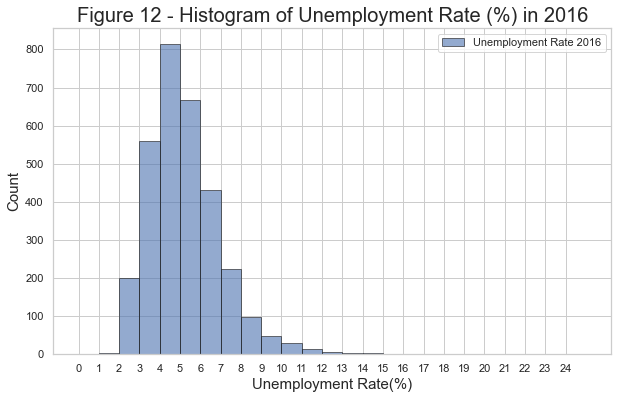

In [82]:
# First we are dealing with unemployment rate varaible
# make histogram for 'unemployment_rate_2016'
plt.figure(figsize=(10, 6))
plt.hist(economic_updated_df_c.Unemployment_rate_2016, bins=range(26), edgecolor='k', alpha=0.6,
        label='Unemployment Rate 2016')
# plt.hist(test_df.Unemployed_2019, bins=range(26), edgecolor='k', alpha=0.6, 
#          label= 'Unemployment Rate 2019-2020')

plt.ylabel('Count', fontsize=15)
plt.xlabel('Unemployment Rate(%)', fontsize=15)

plt.xticks(np.arange(25))
plt.title('Figure 12 - Histogram of Unemployment Rate (%) in 2016', fontsize=20)

plt.legend()
plt.show()

Figure 12 - Histogram of Unemployment Rate (%) in 2016 and 2019-2020)

In [341]:
# Figure 11 Histogram of Unemployment Rate (%) in 2016 and 2019-2020

# It seems the median and the mode of unemployment rate are falling 
# around 4-6 percent
# When comparing between Unemployment Rate 2019-2020, first of all, they are way less people reporting.
# Second, they unemployment rate are much higher in 2019-2020

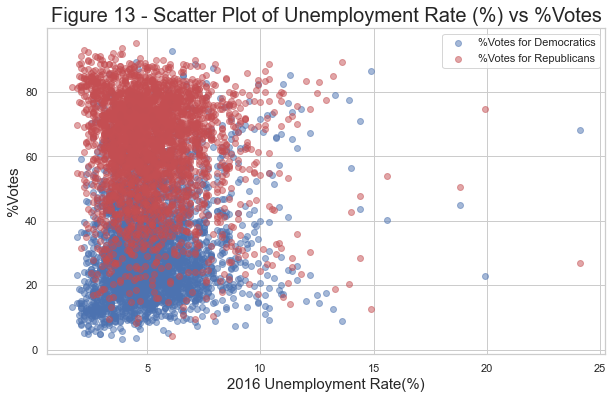

In [83]:
# make scatter plot of unemployment rate vs resposne_dem and response_rep
plt.figure(figsize=(10, 6))

plt.scatter(economic_updated_df_c.Unemployment_rate_2016, economic_updated_df_c['Democrats 2016'], color='b', 
            alpha=0.5, label="%Votes for Democratics")
plt.scatter(economic_updated_df_c.Unemployment_rate_2016, economic_updated_df_c['Republicans 2016'], color='r',
            alpha=0.5, label='%Votes for Republicans')

plt.xlabel('2016 Unemployment Rate(%)', fontsize=15)
plt.ylabel(r'%Votes', fontsize=15)
plt.title('Figure 13 - Scatter Plot of Unemployment Rate (%) vs %Votes', fontsize=20)

plt.legend()

plt.show()

Figure 13 - Scatter Plot of Unemployment Rate (%) vs %Votes

## EDA on Voter Accessibility

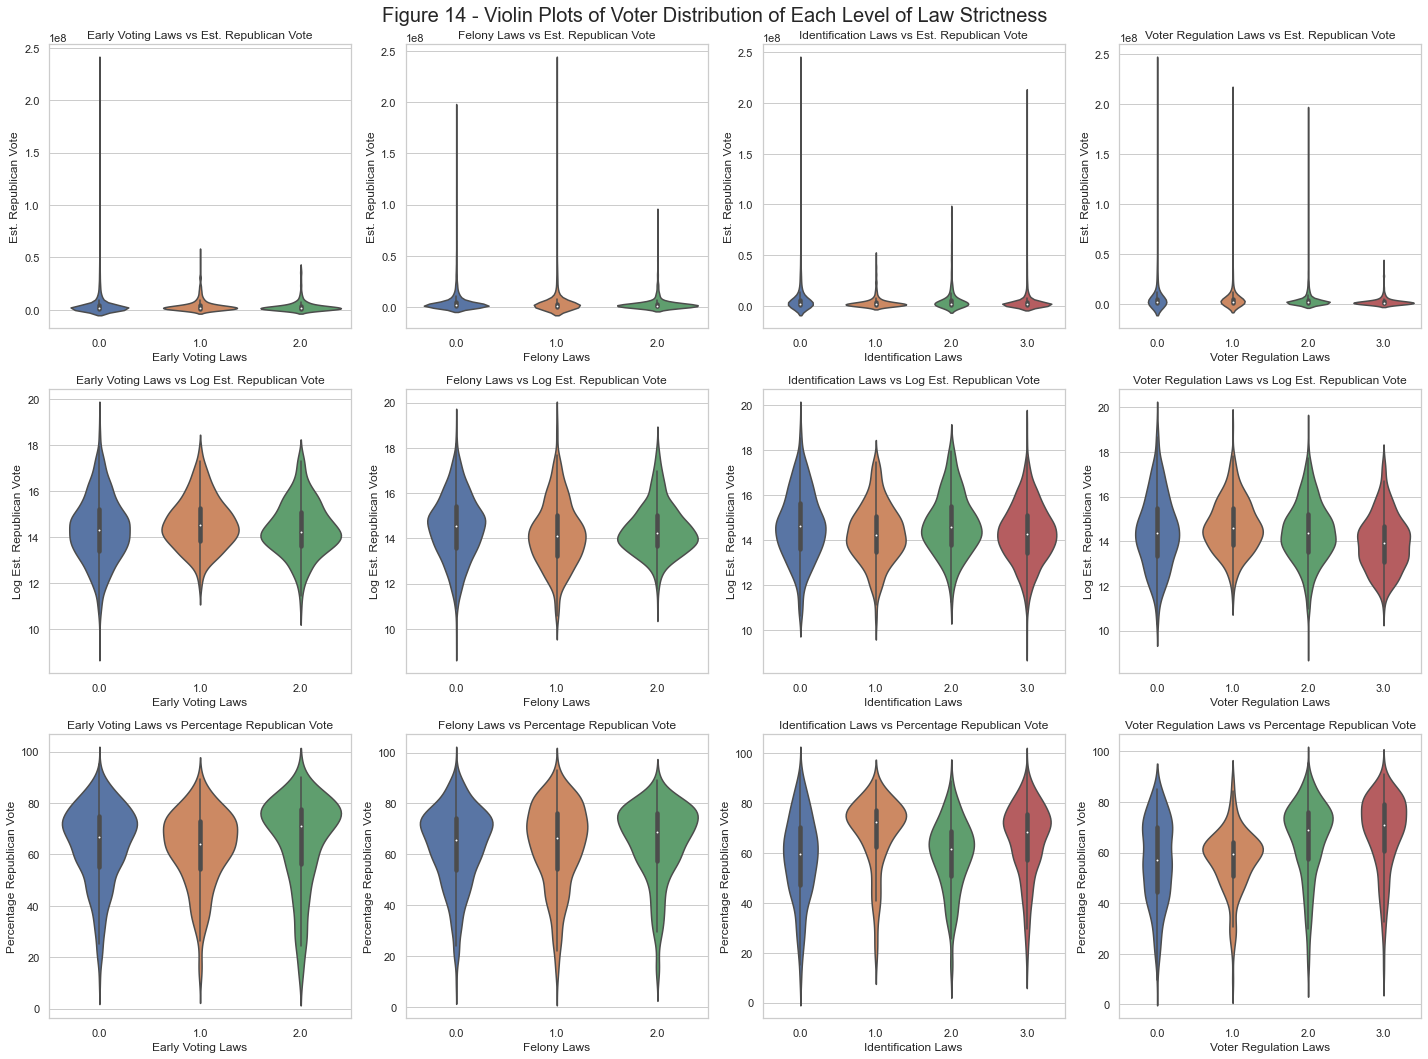

In [85]:
laws = ['early_voting', 'felony_laws', 'id_laws', 'reg_laws']
xlabels = ['Early Voting Laws', 'Felony Laws', 'Identification Laws', 'Voter Regulation Laws']

responses = ['response_rep', 'log_response_rep', 'Republicans 2016']
ylabels = ['Est. Republican Vote', 'Log Est. Republican Vote', 'Percentage Republican Vote']

fig, axes = plt.subplots(3, 4, figsize = (20, 15))
for i in range(3):
    for j in range(4):
        sns.violinplot(ax = axes[i, j], x = data_train[laws[j]], y = data_train[responses[i]])
        axes[i, j].set_xlabel(xlabels[j])
        axes[i, j].set_ylabel(ylabels[i])
        axes[i, j].set_title(xlabels[j] + ' vs ' + ylabels[i])
        
        
plt.suptitle('Figure 14 - Violin Plots of Voter Distribution of Each Level of Law Strictness', fontsize = 20)
plt.tight_layout()
plt.show()

Figure 14 - Violin Plots of Voter Distribution of Each Level of Law Strictness

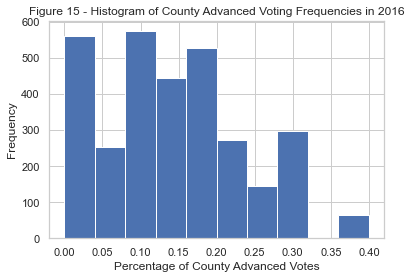

In [86]:
# violin plots of early voting law data
# plot against republican vote count, logged republic vote count, and percentage of republican votes by county
plt.hist(data_train['perc_adv'])
plt.title('Figure 15 - Histogram of County Advanced Voting Frequencies in 2016')
plt.xlabel('Percentage of County Advanced Votes')
plt.ylabel('Frequency')
plt.show()

Figure 15 - Histogram of County Advanced Voting Frequencies in 2016

### A Brief look at the Correlation Between All Features

In [95]:
# Subsetting for the relevant features
voting = data_train[laws]
economics = economic_df.drop(['State', 'FIPS', 'County', 'lag_response_dem', 'lag_response_rep', 'Democrats 2016', 'Republicans 2016'], axis = 1)

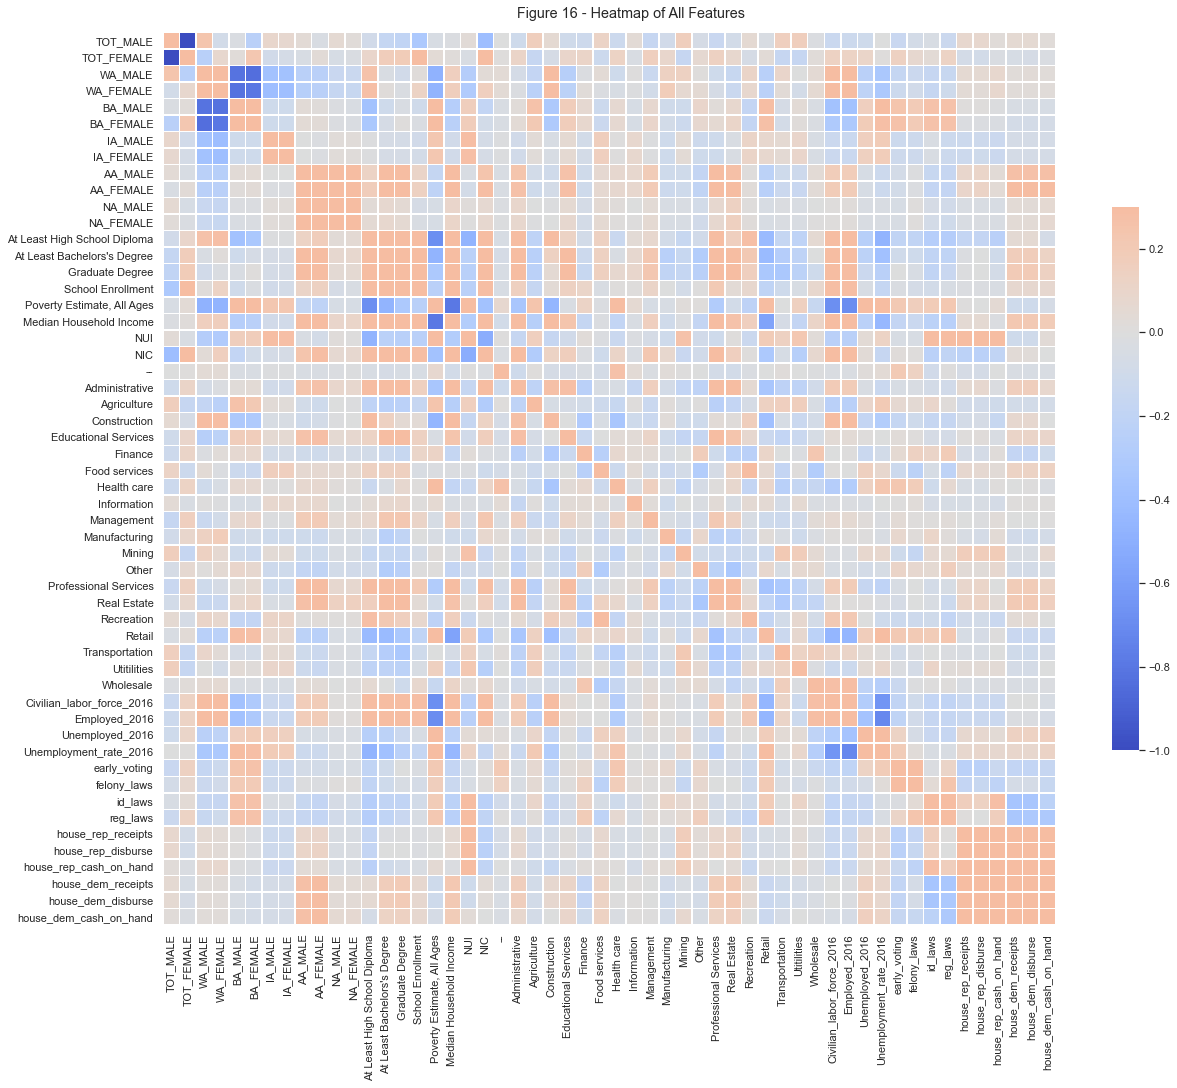

In [96]:
# Merging the features 
full_feature_df = pd.concat([demographic_business, economics, voting, finance],axis=1)

# Calculating correlation
full_merge_cor=full_feature_df.corr(method="pearson")

###Heatmap for chosen variables
f, ax = plt.subplots(figsize=(20, 20))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(full_merge_cor, cmap="coolwarm", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.suptitle("Figure 16 - Heatmap of All Features", x = .45, y = .83)
plt.show()

Figure 16 - Heatmap of All Features

# Baseline Model Analyses 
## Analysis on 2016 Presidential Election 
### Using Democratic Votes as the Base for the Response Variables

In [97]:
## Building our model
# Initialie our predictor sets and I am training with response variables 'response_dem'
state = ['State']
demograph_pred = list(demographic_business.columns)
economic_pred = ['Unemployment_rate_2016']
financial_pred = ['house_dem_receipts', 'house_dem_disburse', 'house_dem_cash_on_hand', 'house_rep_receipts', 'house_rep_disburse', 'house_rep_cash_on_hand']
voting_pred = ['bal2016/popu2016', 'early_voting', 'felony_laws', 'id_laws', 'reg_laws']
consistency_pred = ['lag_response_dem']


# all response variables
train_response1_D = 'response_dem' # votes weighed with whole population
train_response2_D = 'log_response_dem' # log transformed votes
train_response3_D = 'Democrats 2016' # percentage votes for democrats

# all predictors
train_pred_D = demograph_pred + economic_pred + financial_pred + voting_pred + consistency_pred

# all predictors + resposne variables
train_pred_response_D = state + train_pred_D + [train_response1_D] + [train_response2_D] + [train_response3_D]


In [98]:
#train_pred in list(train_df.columns)
for pred in train_pred_D:
    if pred not in list(data_train.columns):
        print(pred)

# This confirms that all predictors in our selected are in the training set.

In [99]:
# Here, i'm checking if there are any null values
# So, first, I need to replace all the missing values
# of business patterns with 0

business_nan = data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1]
business_nan_fill = business_nan.fillna(0)
data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1] = business_nan_fill


In [100]:
# All the nan has been filled
business_nan_fill[business_nan_fill.isnull().any(axis=1)]

Empty DataFrame
Columns: [--, Administrative, Agriculture, Construction, Educational Services, Finance, Food services, Health care, Information, Management, Manufacturing, Mining, Other, Professional Services, Real Estate, Recreation, Retail, Transportation, Utitilities, Wholesale]
Index: []

In [101]:
# Now I'm checking the whole train_df
has_null = data_train[train_pred_response_D].isnull()
null_boolean = has_null.any(axis=1)

null_rows = data_train[train_pred_response_D][null_boolean]
null_rows.head()

State   TOT_MALE  TOT_FEMALE    WA_MALE  WA_FEMALE   BA_MALE  BA_FEMALE   IA_MALE  IA_FEMALE    AA_MALE  AA_FEMALE   NA_MALE  NA_FEMALE  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  School Enrollment  Poverty Estimate, All Ages  Median Household Income        NUI        NIC      --  Administrative  Agriculture  Construction  Educational Services  Finance  Food services  Health care  Information  Management  Manufacturing  Mining  Other  Professional Services  Real Estate  Recreation  Retail  Transportation  Utitilities  Wholesale  Unemployment_rate_2016  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand  house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand  bal2016/popu2016  early_voting  felony_laws  id_laws  reg_laws  lag_response_dem  response_dem  log_response_dem  Democrats 2016
67  Alaska  51.440870   48.559130  35.536587  32.012840  0.452324   0.335595  7.032903   7.164223   3.647771   4.421099  0.160502   0.145911                          92.5                         24.2              7.6              67.40                    9.082950                  67125.0  14.131466  71.189903   602.0           140.0         90.0         340.0                  25.0     85.0          315.0        240.0         75.0        35.0           65.0    15.0  235.0                  165.0        145.0       115.0   525.0           335.0          0.0       60.0                     6.5          1102309.77          1098098.09                 4211.68          1103561.86          1322055.12               269726.86          0.069867           0.0          1.0      1.0       0.0               NaN           NaN               NaN             NaN
68  Alaska  52.235423   47.764577  43.823894  39.724738  0.704963   0.483101  3.503683   3.188659   0.577224   0.941231  0.209376   0.161354                          91.8                         20.8              6.3              73.60                    9.259597                  71793.0  13.787109  73.960564  2204.0           635.0         60.0        2330.0                 130.0    340.0         1080.0       1530.0        170.0        40.0          230.0    55.0  945.0                  835.0        415.0       290.0  1205.0           440.0         40.0      230.0                     8.2          1102309.77          1098098.09                 4211.68          1103561.86          1322055.12               269726.86          0.069867           0.0          1.0      1.0       0.0               NaN           NaN               NaN             NaN
69  Alaska  66.222612   33.777388  24.943032   9.553024  6.275197   0.771253  6.941280   5.521472  23.856266  15.600351  1.822962   0.543383                          70.4                          9.0              1.3              41.85                    7.677476                  78151.0  19.877301  69.342682   115.0            35.0         35.0          25.0                   0.0     10.0           45.0         60.0         15.0         0.0           40.0     5.0   45.0                   15.0         15.0         5.0    55.0           105.0          0.0       65.0                     3.3          1102309.77          1098098.09                 4211.68          1103561.86          1322055.12               269726.86          0.069867           0.0          1.0      1.0       0.0               NaN           NaN               NaN             NaN
70  Alaska  52.822086   47.177914  40.582822  36.012270  1.165644   0.429448  5.797546   4.907975   1.380368   1.779141  0.644172   0.122699                          95.5                         27.4             10.5              80.50                    8.128834                  60540.0  17.638037  64.938650   172.0            20.0        125.0          65.0                  10.0     15.0           70.0         55.0         25.0         5.0           30.0     0.0   80.0                   35.0         20.0        20.0   150.0            90.0          5.0       40.0                  

In [102]:
## Same again, a lot of them are from Alaska, so we are 
## going to drop them for now. 
train_df_final_D = data_train[train_pred_response_D].dropna()
train_df_final_D = train_df_final_D.drop('State', axis = 1)
train_df_final_D.head()

TOT_MALE  TOT_FEMALE    WA_MALE  WA_FEMALE    BA_MALE  BA_FEMALE   IA_MALE  IA_FEMALE   AA_MALE  AA_FEMALE   NA_MALE  NA_FEMALE  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  School Enrollment  Poverty Estimate, All Ages  Median Household Income        NUI        NIC      --  Administrative  Agriculture  Construction  Educational Services  Finance  Food services  Health care  Information  Management  Manufacturing  Mining   Other  Professional Services  Real Estate  Recreation  Retail  Transportation  Utitilities  Wholesale  Unemployment_rate_2016  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand  house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand  bal2016/popu2016  early_voting  felony_laws  id_laws  reg_laws  lag_response_dem  response_dem  log_response_dem  Democrats 2016
0  52.801674   47.198326  26.269085  23.525537  25.246067  22.700147  0.352631   0.232504  0.209254   0.224754  0.108502   0.050376                          71.9                         13.5              6.0              67.85                   26.300085                  32884.0   8.726653  61.012943   452.0            30.0         65.0         115.0                  25.0    210.0          255.0        215.0         25.0         0.0          135.0    20.0   180.0                  160.0        100.0        25.0   440.0           145.0         40.0       75.0                     8.3          1935424.42          1389839.56               964586.58          7539913.77          6867367.47              3303589.32          0.000493           2.0          1.0      3.0       2.0          1.047921  1.204114e+06         14.001255       46.660250
1  48.387041   51.612959  25.207528  25.781559  21.261494  23.669331  0.287016   0.264673  0.290453   0.544814  0.132337   0.142648                          76.9                         11.9              3.4              69.90                   19.090831                  38617.0   9.229183  76.201770   781.0           135.0         55.0         370.0                  25.0    330.0          435.0        335.0         30.0        30.0          175.0    10.0   525.0                  240.0        180.0        35.0   775.0           115.0         20.0       75.0                     5.5          1935424.42          1389839.56               964586.58          7539913.77          6867367.47              3303589.32          0.000493           2.0          1.0      3.0       2.0          1.041426  2.911987e+06         14.884346       50.047032
2  50.080668   49.919332  45.537946  46.142166   2.518111   2.015121  0.831989   0.657999  0.221442   0.234096  0.075923   0.155009                          69.6                         11.8              4.2              68.90                   19.841195                  37049.0  10.815855  71.911676   523.0            30.0         70.0         175.0                   0.0    275.0          215.0        260.0         50.0        30.0          210.0    15.0   290.0                  130.0         95.0        35.0   485.0           130.0         15.0       95.0                     5.9          1935424.42          1389839.56               964586.58          7539913.77          6867367.47              3303589.32          0.000493           2.0          1.0      3.0       2.0          0.982311  5.809232e+05         13.272374       18.377248
3  48.384150   51.615850  40.779622  42.923675   5.725997   6.580305  0.198786   0.198786  0.980680   1.190826  0.027925   0.028871                          91.5                         39.6             12.2              80.90                    7.764978                  74212.0   6.300111  78.840128  5132.0          1615.0         75.0        2335.0                 285.0   2065.0         1855.0       2505.0        530.0       285.0          755.0    70.0  2375.0                 3110.0       1110.0       365.0  3325.0           460.0        165.0     2310.0                     4.3          1935424.42          138

In [103]:
## First, standardize all the training data
## The scaler can be used for future testing data
scaler = StandardScaler().fit(train_df_final_D)
train_df_final_D_s = scaler.transform(train_df_final_D)
train_df_final_D_s = pd.DataFrame(train_df_final_D_s, columns=train_df_final_D.columns)

In [104]:
# Describing data
train_df_final_D_s.describe()

TOT_MALE    TOT_FEMALE       WA_MALE     WA_FEMALE       BA_MALE     BA_FEMALE       IA_MALE     IA_FEMALE       AA_MALE     AA_FEMALE       NA_MALE     NA_FEMALE  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  School Enrollment  Poverty Estimate, All Ages  Median Household Income           NUI           NIC            --  Administrative   Agriculture  Construction  Educational Services       Finance  Food services   Health care   Information    Management  Manufacturing        Mining         Other  Professional Services   Real Estate    Recreation        Retail  Transportation   Utitilities     Wholesale  Unemployment_rate_2016  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand  house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand  bal2016/popu2016  early_voting   felony_laws       id_laws      reg_laws  lag_response_dem  response_dem  log_response_dem  Democrats 2016
count  3.110000e+03  3.110000e+03  3.110000e+03  3.110000e+03  3.110000e+03  3.110000e+03  3.110000e+03  3.110000e+03  3.110000e+03  3.110000e+03  3.110000e+03  3.110000e+03                  3.110000e+03                 3.110000e+03     3.110000e+03       3.110000e+03                3.110000e+03             3.110000e+03  3.110000e+03  3.110000e+03  3.110000e+03    3.110000e+03  3.110000e+03  3.110000e+03          3.110000e+03  3.110000e+03   3.110000e+03  3.110000e+03  3.110000e+03  3.110000e+03   3.110000e+03  3.110000e+03  3.110000e+03           3.110000e+03  3.110000e+03  3.110000e+03  3.110000e+03    3.110000e+03  3.110000e+03  3.110000e+03            3.110000e+03        3.110000e+03        3.110000e+03            3.110000e+03        3.110000e+03        3.110000e+03            3.110000e+03      3.110000e+03  3.110000e+03  3.110000e+03  3.110000e+03  3.110000e+03      3.110000e+03  3.110000e+03      3.110000e+03    3.110000e+03
mean   1.818624e-15 -1.779784e-15 -5.757452e-16  2.604562e-16  5.483288e-17 -3.655525e-17  2.741644e-17  9.138813e-18 -4.112466e-17 -4.797877e-17  2.741644e-17  2.056233e-17                  9.184507e-16                -1.279434e-16     8.681873e-17      -1.279434e-16               -1.919151e-16            -2.421786e-16  1.279434e-16  2.101927e-16  1.370822e-17    2.284703e-18  1.827763e-17  1.370822e-17          9.138813e-18 -1.599292e-17   4.569407e-18  1.370822e-17  1.028116e-17 -6.854110e-18  -1.256587e-17  2.741644e-17 -2.741644e-17           9.138813e-18  5.711758e-18 -3.427055e-18 -6.854110e-18   -1.142352e-17 -4.340936e-17 -4.569407e-18           -3.655525e-17        1.005269e-16        1.690680e-16           -1.188046e-16        9.138813e-17       -7.311051e-17            3.655525e-17     -6.397169e-17 -7.311051e-17 -3.655525e-17  3.655525e-17  4.569407e-17      6.123005e-16 -4.112466e-17      4.797877e-16   -1.233740e-16
std    1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00                  1.000161e+00                 1.000161e+00     1.000161e+00       1.000161e+00                1.000161e+00             1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00    1.000161e+00  1.000161e+00  1.000161e+00          1.000161e+00  1.000161e+00   1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00   1.000161e+00  1.000161e+00  1.000161e+00           1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00    1.000161e+00  1.000161e+00  1.000161e+00            1.000161e+00        1.000161e+00        1.000161e+00            1.000161e+00        1.000161e+00        1.000161e+00            1.000161e+00      1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00      1.000161e+00  1.000161e+00      1.000161e+00    1.000161e+00
min   -3.103562e+00 -8.966330e+00 -4.751588e+00 -4.744004e+00 -6.709174e-01 -6.032074e-01 -3.164332e-01 -3.017634e-01 -5.256077e-01 -5.566957e-01 -2.768823e-01 -2.652377e-01                 -7.133301e+00                -1.767484e+0

In [105]:
# Initialize our X train and y train
Xtrain_D = train_df_final_D_s[train_pred_D].values

ytrain1_D = train_df_final_D_s['response_dem'].values
ytrain2_D = train_df_final_D_s['log_response_dem'].values
ytrain3_D = train_df_final_D_s['Democrats 2016'].values

# Get both shapes for both X and y
print(Xtrain_D.shape)
print(ytrain1_D.shape)
print(ytrain2_D.shape)
print(ytrain3_D.shape)

(3110, 53)
(3110,)
(3110,)
(3110,)


#### Decision Tree Base Model (Democrat Votes)

In [106]:
depths = list(range(1, 50))

def calc_meanstd(X_train, y_train, depths):
    train_scores = []
    cvmeans = []
    cvstds = []
    
    for depth in depths:
        dtree = DecisionTreeRegressor(max_depth=depth).fit(X_train, y_train)
        train_score = dtree.score(X_train, y_train)
        
        # append train score
        train_scores.append(train_score)
        
        # start cv
        cv = cross_val_score(estimator=dtree, X=X_train, y=y_train, 
                            scoring='r2', cv=5)
        
        # append to the means and stds
        cvmeans.append(cv.mean())
        cvstds.append(cv.std())
    
    # transform into np arrays
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    
    return cvmeans, cvstds, train_scores

cvmeans1_D, cvstds1_D, train_score1_D = calc_meanstd(Xtrain_D, ytrain1_D, depths)
cvmeans2_D, cvstds2_D, train_score2_D = calc_meanstd(Xtrain_D, ytrain2_D, depths)
cvmeans3_D, cvstds3_D, train_score3_D = calc_meanstd(Xtrain_D, ytrain3_D, depths)
    


KeyboardInterrupt: 

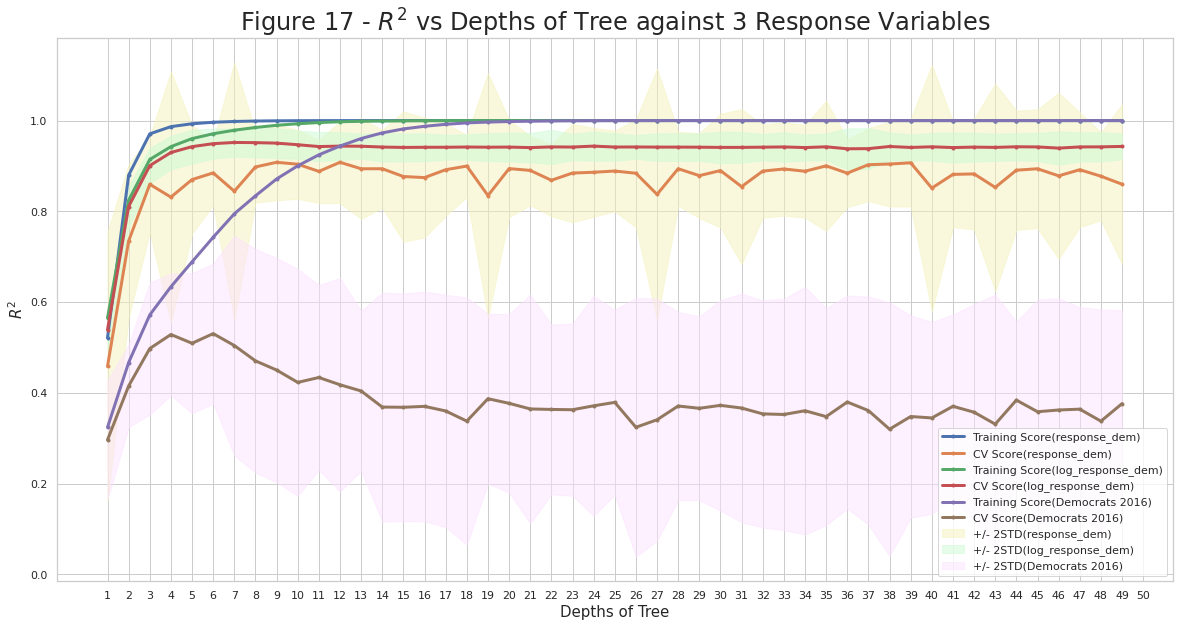

In [358]:
## make the plot
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(depths, train_score1_D, '.-', label='Training Score(response_dem)', lw=3)
ax.plot(depths, cvmeans1_D, '.-', label='CV Score(response_dem)', lw=3)
plt.fill_between(depths, cvmeans1_D+2*cvstds1_D, cvmeans1_D-2*cvstds1_D, color='#F5F3BB', 
                alpha=0.5, label='+/- 2STD(response_dem)')

ax.plot(depths, train_score2_D, '.-', label='Training Score(log_response_dem)', lw=3)
ax.plot(depths, cvmeans2_D, '.-', label='CV Score(log_response_dem)', lw=3)
plt.fill_between(depths, cvmeans2_D+2*cvstds2_D, cvmeans2_D-2*cvstds2_D, color='#CDFBD5', 
                alpha=0.5, label='+/- 2STD(log_response_dem)')

ax.plot(depths, train_score3_D, '.-', label='Training Score(Democrats 2016)', lw=3)
ax.plot(depths, cvmeans3_D, '.-', label='CV Score(Democrats 2016)', lw=3)
plt.fill_between(depths, cvmeans3_D+2*cvstds3_D, cvmeans3_D-2*cvstds3_D, color='#FDE2FF', 
                alpha=0.5, label='+/- 2STD(Democrats 2016)')

ax.set_xlabel('Depths of Tree', fontsize=15)
ax.set_ylabel('$R^{2}$', fontsize=15)
ax.set_title('Figure 17 - $R^{2}$ vs Depths of Tree against 3 Response Variables', fontsize=24)

ax.set_xticks(np.arange(1,51))

ax.legend()
plt.show()



Figure 17 - $R^{2}$ vs Depths of Tree against 3 Response Variables

In [359]:
## Find the best depths for each response variables
best_depth1_D = cvmeans1_D.argmax()+1
best_depth2_D = cvmeans2_D.argmax()+1
best_depth3_D = cvmeans3_D.argmax()+1

best_score1_D = cvmeans1_D.max()
best_score2_D = cvmeans2_D.max()
best_score3_D = cvmeans3_D.max()

best_train_score1_D = train_score1_D[best_depth1_D-1]
best_train_score2_D = train_score2_D[best_depth2_D-1]
best_train_score3_D = train_score3_D[best_depth3_D-1]

print("The best depth with estimated absolute votes for Democrats in each county '{0}' is {1}; has training score: {2:.4f} has a CV score: {3:.4f}".format(train_response1_D, best_depth1_D, best_train_score1_D, best_score1_D))
print("The best depth with log of estimated absolute votes for Democrats in each country '{0}' is {1}; has training score: {2:.4f} has a CV score: {3:.4f}".format(train_response2_D, best_depth2_D, best_train_score2_D, best_score2_D))
print("The best depth with percent of county who voted for Democrats '{0}' is {1}; has training score: {2:.4f} has a CV score: {3:.4f}".format(train_response3_D, best_depth3_D, best_train_score3_D, best_score3_D))


The best depth with estimated absolute votes for Democrats in each county 'response_dem' is 12; has training score: 0.9999 has a CV score: 0.9081
The best depth with log of estimated absolute votes for Democrats in each country 'log_response_dem' is 7; has training score: 0.9787 has a CV score: 0.9518
The best depth with percent of county who voted for Democrats 'Democrats 2016' is 6; has training score: 0.7429 has a CV score: 0.5305


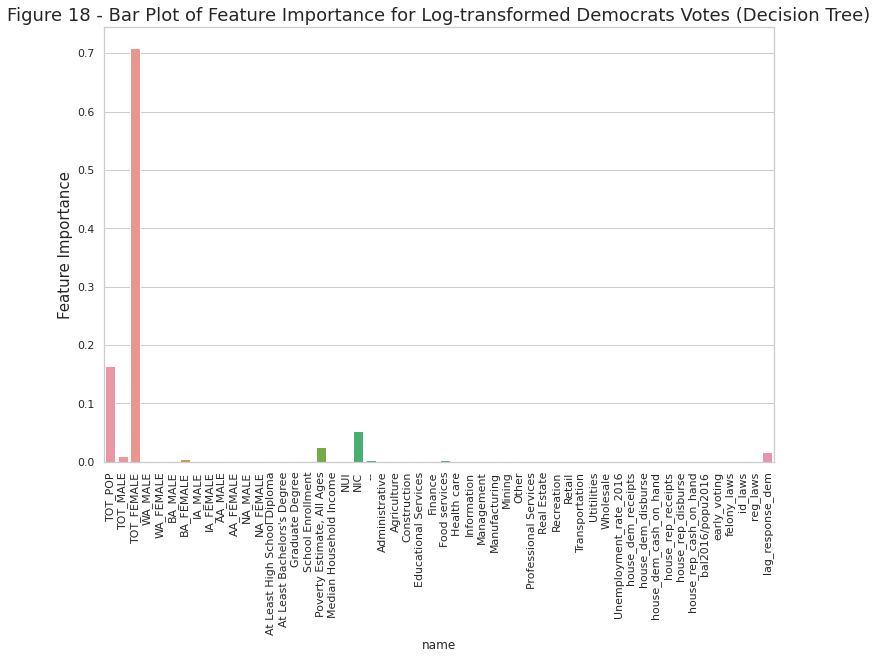

In [360]:
# It seems that dtree with depth of 7 gives the best score on 'log_response_dem' variable
# recreate a tree model with depth of 7

# recreate the X_train and y_train
Xtrain_D = train_df_final_D_s[train_pred_D]
ytrain_log_D = train_df_final_D_s['log_response_dem']

dtree = DecisionTreeRegressor(max_depth=best_depth2_D).fit(Xtrain_D, ytrain_log_D)
feature = pd.DataFrame(dtree.feature_importances_)

feature = feature.copy()
feature['name'] = Xtrain_D.columns

plt.figure(figsize=(12, 8))

ax = sns.barplot(x='name', y=0, data=feature)
ax.set_ylabel("Feature Importance", fontsize=15)
ax.set_title("Figure 18 - Bar Plot of Feature Importance for Log-transformed Democrats Votes (Decision Tree)", fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()


Figure 18 - Bar Plot of Feature Importance for Log-transformed Democrats Votes (Decision Tree)

#### RidgeCV Base Model (Democrat Votes)

In [361]:
# reinitialize our X train and y train
Xtrain_D = train_df_final_D_s[train_pred_D].values

ytrain1_D = train_df_final_D_s['response_dem'].values
ytrain2_D = train_df_final_D_s['log_response_dem'].values
ytrain3_D = train_df_final_D_s['Democrats 2016'].values

# Ridge Regression with CV 
# Using 5 folds

# 'response_dem' response variable
ridgecv1_D=RidgeCV(cv=5) # change it to 5 for consistency
ridgecv1_D.fit(Xtrain_D, ytrain1_D)
score1_D=ridgecv1_D.score(Xtrain_D, ytrain1_D)
cv_best1_D=ridgecv1_D.best_score_

# 'log_response_dem' response variable
ridgecv2_D=RidgeCV(cv=5) 
ridgecv2_D.fit(Xtrain_D, ytrain2_D)
score2_D=ridgecv2_D.score(Xtrain_D, ytrain2_D)
cv_best2_D=ridgecv2_D.best_score_

# 'democrats 2016' response variable
ridgecv3_D=RidgeCV(cv=5)
ridgecv3_D.fit(Xtrain_D, ytrain3_D)
score3_D=ridgecv3_D.score(Xtrain_D, ytrain3_D)
cv_best3_D=ridgecv3_D.best_score_

print("With '{0}', RidgeCV has a training score: {1:.4f}, validation score: {2:.4f}".format(train_response1_D, score1_D, cv_best1_D)) 
print("With '{0}', RidgeCV has a training score: {1:.4f}, validation score: {2:.4f}".format(train_response2_D, score2_D, cv_best2_D)) 
print("With '{0}', RidgeCV has a training score: {1:.4f}, validation score: {2:.4f}".format(train_response3_D, score3_D, cv_best3_D)) 


With 'response_dem', RidgeCV has a training score: 0.9944, validation score: 0.9834
With 'log_response_dem', RidgeCV has a training score: 0.7211, validation score: 0.4123
With 'Democrats 2016', RidgeCV has a training score: 0.6792, validation score: 0.5683


In [362]:
# so here we are training with 'response_dem'

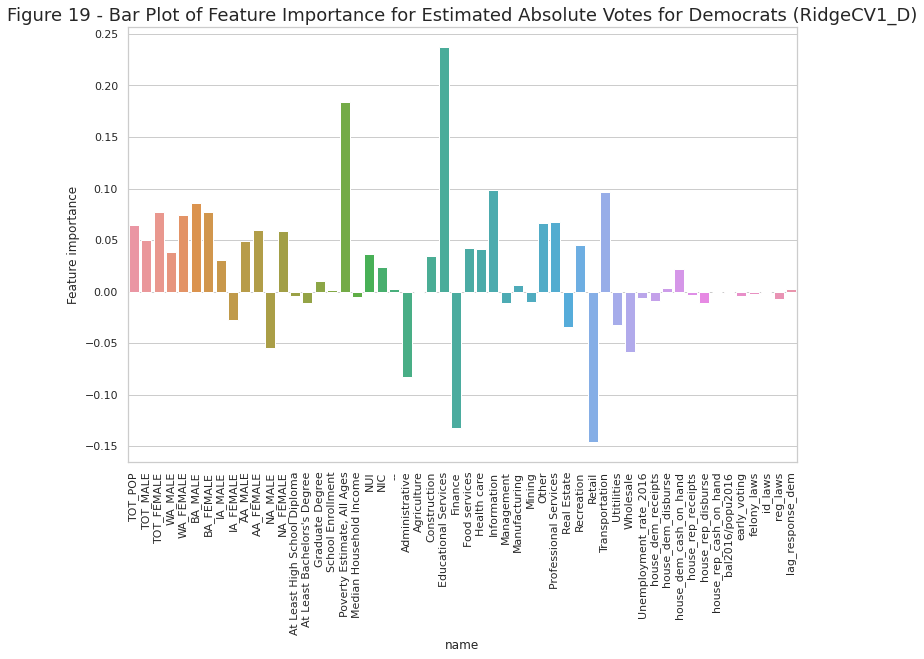

In [363]:
# recreate the X_train and y_train. 
# AND focusing on response_dem and it gives us the best validation score
Xtrain_D = train_df_final_D_s[train_pred_D]

ridge_feature=pd.DataFrame(ridgecv1_D.coef_)
ridge_feature=ridge_feature.copy()
ridge_feature['name']=Xtrain_D.columns

plt.figure(figsize=(12,8))

ax = sns.barplot(x="name", y=0, data=ridge_feature)
ax.set_ylabel("Feature importance")
ax.set_title("Figure 19 - Bar Plot of Feature Importance for Estimated Absolute Votes for Democrats (RidgeCV1_D)", fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

Figure 19 - Bar Plot of Feature Importance for Estimated Absolute Votes for Democrats (RidgeCV1_D)

In [364]:
## Now focusing on the votes counted towards the republicans as predictor. Here was want to see which 
## party offers the predictive ability for the model given the data.
## Repeating all of the analysis above 

### Using Republican Votes as the Base for the Response Variables

In [365]:
## Building our model
# Reinitializing our predictor sets and I am training with response variables 'response_dem'
state = ['State']
demograph_pred = list(demographic_business.columns)
economic_pred = ['Unemployment_rate_2016']
financial_pred = ['house_dem_receipts', 'house_dem_disburse', 'house_dem_cash_on_hand', 'house_rep_receipts', 'house_rep_disburse', 'house_rep_cash_on_hand']
voting_pred = ['bal2016/popu2016', 'early_voting', 'felony_laws', 'id_laws', 'reg_laws']
consistency_pred = ['lag_response_dem']

# all response variables
train_response1_R = 'response_rep' # votes weighed with whole population
train_response2_R = 'log_response_rep' # log transformed votes
train_response3_R = 'Republicans 2016' # percentage votes for democrats

# all predictors
train_pred_R = demograph_pred + economic_pred + financial_pred + voting_pred + consistency_pred

# all predictors + resposne variables
train_pred_response_R = state + train_pred_R + [train_response1_R] + [train_response2_R] + [train_response3_R]


In [366]:
# Now I'm checking the whole data_train
has_null = data_train[train_pred_response_R].isnull()
null_boolean = has_null.any(axis=1)

null_rows = data_train[train_pred_response_R][null_boolean]
null_rows.head()

State  TOT_POP  TOT_MALE  TOT_FEMALE  WA_MALE  WA_FEMALE  BA_MALE  BA_FEMALE  IA_MALE  IA_FEMALE  AA_MALE  AA_FEMALE  NA_MALE  NA_FEMALE  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  School Enrollment  Poverty Estimate, All Ages  Median Household Income      NUI      NIC      --  Administrative  Agriculture  Construction  Educational Services  Finance  Food services  Health care  Information  Management  Manufacturing  Mining  Other  Professional Services  Real Estate  Recreation  Retail  Transportation  Utitilities  Wholesale  Unemployment_rate_2016  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand  house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand  bal2016/popu2016  early_voting  felony_laws  id_laws  reg_laws  lag_response_dem  response_rep  log_response_rep  Republicans 2016
67  Alaska    13707      7051        6656     4871       4388       62         46      964        982      500        606       22         20                          92.5                         24.2              7.6              67.40                      1245.0                  67125.0   1937.0   9758.0   602.0           140.0         90.0         340.0                  25.0     85.0          315.0        240.0         75.0        35.0           65.0    15.0  235.0                  165.0        145.0       115.0   525.0           335.0          0.0       60.0                     6.5          1102309.77          1098098.09                 4211.68          1103561.86          1322055.12               269726.86          0.069867           0.0          1.0      1.0       0.0               NaN           NaN               NaN               NaN
68  Alaska   104119     54387       49732    45629      41361      734        503     3648       3320      601        980      218        168                          91.8                         20.8              6.3              73.60                      9641.0                  71793.0  14355.0  77007.0  2204.0           635.0         60.0        2330.0                 130.0    340.0         1080.0       1530.0        170.0        40.0          230.0    55.0  945.0                  835.0        415.0       290.0  1205.0           440.0         40.0      230.0                     8.2          1102309.77          1098098.09                 4211.68          1103561.86          1322055.12               269726.86          0.069867           0.0          1.0      1.0       0.0               NaN           NaN               NaN               NaN
69  Alaska     5705      3778        1927     1423        545      358         44      396        315     1361        890      104         31                          70.4                          9.0              1.3              41.85                       438.0                  78151.0   1134.0   3956.0   115.0            35.0         35.0          25.0                   0.0     10.0           45.0         60.0         15.0         0.0           40.0     5.0   45.0                   15.0         15.0         5.0    55.0           105.0          0.0       65.0                     3.3          1102309.77          1098098.09                 4211.68          1103561.86          1322055.12               269726.86          0.069867           0.0          1.0      1.0       0.0               NaN           NaN               NaN               NaN
70  Alaska     3260      1722        1538     1323       1174       38         14      189        160       45         58       21          4                          95.5                         27.4             10.5              80.50                       265.0                  60540.0    575.0   2117.0   172.0            20.0        125.0          65.0                  10.0     15.0           70.0         55.0         25.0         5.0           30.0     0.0   80.0                   35.0         20.0        20.0   150.0            90.0          5.0       40.0                     9.0 

In [367]:
## Same again, a lot of them are from Alaska, so we are 
## going to drop them for now. 
train_df_final_R = data_train[train_pred_response_R].dropna()
train_df_final_R = train_df_final_R.drop('State', axis = 1)
train_df_final_R.head()

TOT_POP  TOT_MALE  TOT_FEMALE  WA_MALE  WA_FEMALE  BA_MALE  BA_FEMALE  IA_MALE  IA_FEMALE  AA_MALE  AA_FEMALE  NA_MALE  NA_FEMALE  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  School Enrollment  Poverty Estimate, All Ages  Median Household Income      NUI       NIC      --  Administrative  Agriculture  Construction  Educational Services  Finance  Food services  Health care  Information  Management  Manufacturing  Mining   Other  Professional Services  Real Estate  Recreation  Retail  Transportation  Utitilities  Wholesale  Unemployment_rate_2016  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand  house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand  bal2016/popu2016  early_voting  felony_laws  id_laws  reg_laws  lag_response_dem  response_rep  log_response_rep  Republicans 2016
0    25806     13626       12180     6779       6071     6515       5858       91         60       54         58       28         13                          71.9                         13.5              6.0              67.85                      6787.0                  32884.0   2252.0   15745.0   452.0            30.0         65.0         115.0                  25.0    210.0          255.0        215.0         25.0         0.0          135.0    20.0   180.0                  160.0        100.0        25.0   440.0           145.0         40.0       75.0                     8.3          1935424.42          1389839.56               964586.58          7539913.77          6867367.47              3303589.32          0.000493           2.0          1.0      3.0       2.0          1.047921  1.348916e+06         14.114812         52.271415
1    58185     28154       30031    14667      15001    12371      13772      167        154      169        317       77         83                          76.9                         11.9              3.4              69.90                     11108.0                  38617.0   5370.0   44338.0   781.0           135.0         55.0         370.0                  25.0    330.0          435.0        335.0         30.0        30.0          175.0    10.0   525.0                  240.0        180.0        35.0   775.0           115.0         20.0       75.0                     5.5          1935424.42          1389839.56               964586.58          7539913.77          6867367.47              3303589.32          0.000493           2.0          1.0      3.0       2.0          1.041426  2.800396e+06         14.845272         48.129181
2    31611     15831       15780    14395      14586      796        637      263        208       70         74       24         49                          69.6                         11.8              4.2              68.90                      6272.0                  37049.0   3419.0   22732.0   523.0            30.0         70.0         175.0                   0.0    275.0          215.0        260.0         50.0        30.0          210.0    15.0   290.0                  130.0         95.0        35.0   485.0           130.0         15.0       95.0                     5.9          1935424.42          1389839.56               964586.58          7539913.77          6867367.47              3303589.32          0.000493           2.0          1.0      3.0       2.0          0.982311  2.502967e+06         14.732987         79.180259
3   211282    102227      109055    86160      90690    12098      13903      420        420     2072       2516       59         61                          91.5                         39.6             12.2              80.90                     16406.0                  74212.0  13311.0  166575.0  5132.0          1615.0         75.0        2335.0                 285.0   2065.0         1855.0       2505.0        530.0       285.0          755.0    70.0  2375.0                 3110.0       1110.0       365.0  3325.0           460.0        165.0     2310.0                     4.3          1935424.42          1389

In [368]:
## First, standardize all the training data
## The scaler can be used for future testing data
scaler = StandardScaler().fit(train_df_final_R)
train_df_final_R_s = scaler.transform(train_df_final_R)
train_df_final_R_s = pd.DataFrame(train_df_final_R_s, columns=train_df_final_R.columns)

In [369]:
# Initialize our X train and y train
Xtrain_R = train_df_final_R_s[train_pred_R].values

ytrain1_R = train_df_final_R_s['response_rep'].values
ytrain2_R = train_df_final_R_s['log_response_rep'].values
ytrain3_R = train_df_final_R_s['Republicans 2016'].values

#### Decision Tree Base Model (Republican Votes)

In [370]:
cvmeans1_R, cvstds1_R, train_score1_R = calc_meanstd(Xtrain_R, ytrain1_R, depths)
cvmeans2_R, cvstds2_R, train_score2_R = calc_meanstd(Xtrain_R, ytrain2_R, depths)
cvmeans3_R, cvstds3_R, train_score3_R = calc_meanstd(Xtrain_R, ytrain3_R, depths)

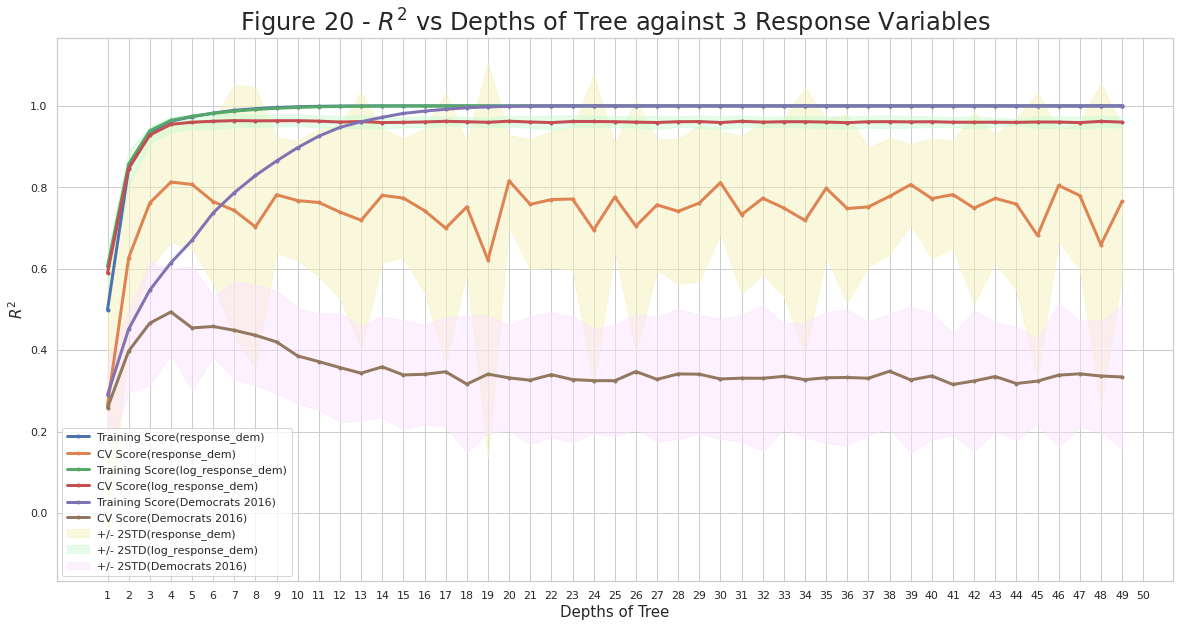

In [371]:
## make the plot
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(depths, train_score1_R, '.-', label='Training Score(response_dem)', lw=3)
ax.plot(depths, cvmeans1_R, '.-', label='CV Score(response_dem)', lw=3)
plt.fill_between(depths, cvmeans1_R+2*cvstds1_R, cvmeans1_R-2*cvstds1_R, color='#F5F3BB', 
                alpha=0.5, label='+/- 2STD(response_dem)')

ax.plot(depths, train_score2_R, '.-', label='Training Score(log_response_dem)', lw=3)
ax.plot(depths, cvmeans2_R, '.-', label='CV Score(log_response_dem)', lw=3)
plt.fill_between(depths, cvmeans2_R+2*cvstds2_R, cvmeans2_R-2*cvstds2_R, color='#CDFBD5', 
                alpha=0.5, label='+/- 2STD(log_response_dem)')

ax.plot(depths, train_score3_R, '.-', label='Training Score(Democrats 2016)', lw=3)
ax.plot(depths, cvmeans3_R, '.-', label='CV Score(Democrats 2016)', lw=3)
plt.fill_between(depths, cvmeans3_R+2*cvstds3_R, cvmeans3_R-2*cvstds3_R, color='#FDE2FF', 
                alpha=0.5, label='+/- 2STD(Democrats 2016)')

ax.set_xlabel('Depths of Tree', fontsize=15)
ax.set_ylabel('$R^{2}$', fontsize=15)
ax.set_title('Figure 20 - $R^{2}$ vs Depths of Tree against 3 Response Variables', fontsize=24)

ax.set_xticks(np.arange(1,51))

ax.legend()
plt.show()

Figure 20 - $R^{2}$ vs Depths of Tree against 3 Response Variables

In [372]:
## Find the best depths for each response variables
best_depth1_R = cvmeans1_R.argmax()+1
best_depth2_R = cvmeans2_R.argmax()+1
best_depth3_R = cvmeans3_R.argmax()+1

best_score1_R = cvmeans1_R.max()
best_score2_R = cvmeans2_R.max()
best_score3_R = cvmeans3_R.max()

best_train_score1_R = train_score1_R[best_depth1_R-1]
best_train_score2_R = train_score2_R[best_depth2_R-1]
best_train_score3_R = train_score3_R[best_depth3_R-1]

print("The best depth with estimated absolute votes for Republicans in each county '{0}' is {1}; has training score: {2:.4f} has a CV score: {3:.4f}".format(train_response1_R, best_depth1_R, best_train_score1_R, best_score1_R))
print("The best depth with log of estimated absolute votes for Republicans in each country '{0}' is {1}; has training score: {2:.4f} has a CV score: {3:.4f}".format(train_response2_R, best_depth2_R, best_train_score2_R, best_score2_R))
print("The best depth with percent of county who voted for Republicans '{0}' is {1}; has training score: {2:.4f} has a CV score: {3:.4f}".format(train_response3_R, best_depth3_R, best_train_score3_R, best_score3_R))


The best depth with estimated absolute votes for Republicans in each county 'response_rep' is 20; has training score: 1.0000 has a CV score: 0.8159
The best depth with log of estimated absolute votes for Republicans in each country 'log_response_rep' is 7; has training score: 0.9871 has a CV score: 0.9639
The best depth with percent of county who voted for Republicans 'Republicans 2016' is 4; has training score: 0.6148 has a CV score: 0.4939


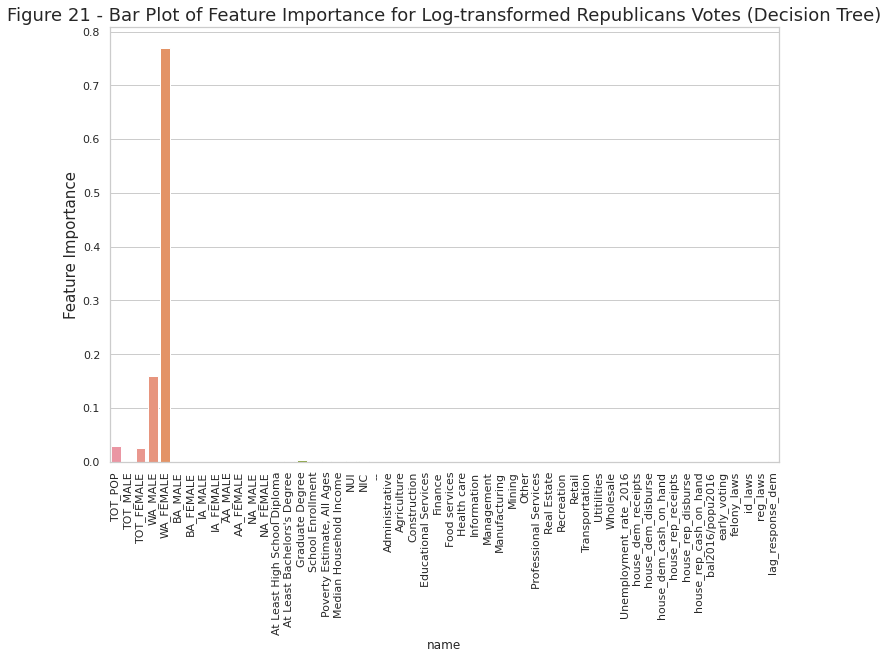

In [373]:
# It seems that dtree with depth of 7 gives the best score on 
# 'log_response_rep' variable. However, we have a higher cv score with log_response_rep than log_response_dem
# recreate a tree model with depth of 7. Moreover, response_dem gets a better score than response_rep.
# Focusing on log_response_rep here.

# recreate the X_train and y_train
Xtrain_R = train_df_final_R_s[train_pred_R]
ytrain_log_R = train_df_final_R_s['log_response_rep']

dtree = DecisionTreeRegressor(max_depth=best_depth2_R).fit(Xtrain_R, ytrain_log_R)
feature = pd.DataFrame(dtree.feature_importances_)

feature = feature.copy()
feature['name'] = Xtrain_R.columns

plt.figure(figsize=(12, 8))

ax = sns.barplot(x='name', y=0, data=feature)
ax.set_ylabel("Feature Importance", fontsize=15)
ax.set_title("Figure 21 - Bar Plot of Feature Importance for Log-transformed Republicans Votes (Decision Tree)", fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()


Figure 21 - Bar Plot of Feature Importance for Log-transformed Republicans Votes (Decision Tree)

#### RidgeCV Base Model (Republican Votes)

In [374]:
# reinitialize our X train and y train
Xtrain_R = train_df_final_R_s[train_pred_R].values

ytrain1_R = train_df_final_R_s['response_rep'].values
ytrain2_R = train_df_final_R_s['log_response_rep'].values
ytrain3_R = train_df_final_R_s['Republicans 2016'].values

# Ridge Regression with CV 
# Using 5 folds

# 'response_rep' response variable
ridgecv1_R=RidgeCV(cv=5) # change it to 5 for consistency
ridgecv1_R.fit(Xtrain_R, ytrain1_R)
score1_R=ridgecv1_R.score(Xtrain_R, ytrain1_R)
cv_best1_R=ridgecv1_R.best_score_

# 'log_response_rep' response variable
ridgecv2_R=RidgeCV(cv=5) 
ridgecv2_R.fit(Xtrain_R, ytrain2_R)
score2_R=ridgecv2_R.score(Xtrain_R, ytrain2_R)
cv_best2_R=ridgecv2_R.best_score_

# 'republicans 2016' response variable
ridgecv3_R=RidgeCV(cv=5)
ridgecv3_R.fit(Xtrain_R, ytrain3_R)
score3_R=ridgecv3_R.score(Xtrain_R, ytrain3_R)
cv_best3_R=ridgecv3_R.best_score_

print("With '{0}', RidgeCV has a training score: {1:.4f}, validation score: {2:.4f}".format(train_response1_R, score1_R, cv_best1_R)) 
print("With '{0}', RidgeCV has a training score: {1:.4f}, validation score: {2:.4f}".format(train_response2_R, score2_R, cv_best2_R)) 
print("With '{0}', RidgeCV has a training score: {1:.4f}, validation score: {2:.4f}".format(train_response3_R, score3_R, cv_best3_R)) 


With 'response_rep', RidgeCV has a training score: 0.9799, validation score: 0.9491
With 'log_response_rep', RidgeCV has a training score: 0.6248, validation score: 0.1755
With 'Republicans 2016', RidgeCV has a training score: 0.6494, validation score: 0.5194


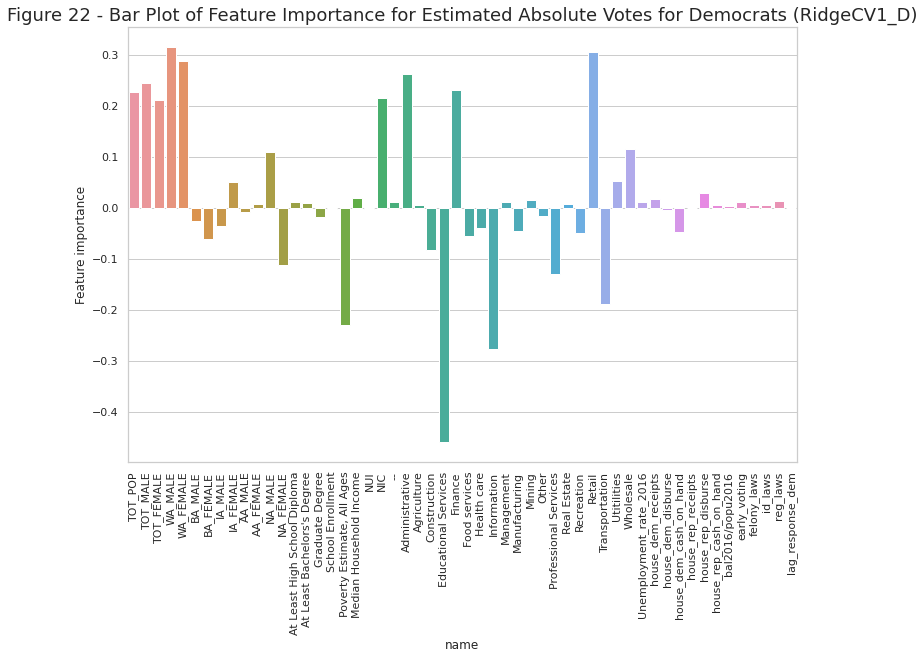

In [375]:
# recreate the X_train and y_train. 
# AND focusing on response_rep as it gives the best R squared 
Xtrain_R = train_df_final_R_s[train_pred_R]

ridge_feature=pd.DataFrame(ridgecv1_R.coef_)
ridge_feature=ridge_feature.copy()
ridge_feature['name']=Xtrain_R.columns

plt.figure(figsize=(12,8))

ax = sns.barplot(x="name", y=0, data=ridge_feature)
ax.set_ylabel("Feature importance")
ax.set_title("Figure 22 - Bar Plot of Feature Importance for Estimated Absolute Votes for Democrats (RidgeCV1_D)", fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

Figure 22 - Bar Plot of Feature Importance for Estimated Absolute Votes for Democrats (RidgeCV1_D)

### Comparisons Between the Different Models and Response Variables

In [391]:
# Putting everything two tables: 

train_scores1 = [best_train_score1_R,
                    best_train_score1_D,
                    best_train_score2_R,
                    best_train_score2_D,
                    best_train_score3_R,
                    best_train_score3_D]

val_scores1 = [best_score1_R,
                best_score1_D,
                best_score2_R,
                best_score2_D,
                best_score3_R,
                best_score3_D]

titles1 = ['Republican Est Votes', 
            'Democrat Est Votes', 
            'Republican Log Est Votes', 
            'Democrat Log Est Votes',
            'Republican Percentage Vote',
            'Democrat Percentage Vote']

df_results1 = pd.DataFrame()
df_results1['Best Single Tree Depth vs.'] = titles1
df_results1['Training Accuracy'] = train_scores1
df_results1['Validation Accuracy'] = val_scores1




In [392]:
train_scores2 = [score1_R,
                    score1_D,
                    score2_R,
                    score2_D,
                    score3_D,
                    score3_R]

val_scores2 = [cv_best1_R,
                cv_best1_D,
                cv_best2_R,
                cv_best2_D,
                cv_best3_R,
                cv_best3_D]

titles2 = ['Republican Est Votes', 
            'Democrat Est Votes', 
            'Republican Log Est Votes', 
            'Democrat Log Est Votes',
            'Republican Percentage Vote',
            'Democrat Percentage Vote']

df_results2 = pd.DataFrame()
df_results2['Ridge Cross Validation vs.'] = titles2
df_results2['Training Accuracy'] = train_scores2
df_results2['Validation Accuracy'] = val_scores2

display(df_results1), display(df_results2)


Best Single Tree Depth vs.  Training Accuracy  Validation Accuracy
0        Republican Est Votes           1.000000             0.815904
1          Democrat Est Votes           0.999928             0.908070
2    Republican Log Est Votes           0.987124             0.963919
3      Democrat Log Est Votes           0.978730             0.951764
4  Republican Percentage Vote           0.614806             0.493926
5    Democrat Percentage Vote           0.742869             0.530534

Ridge Cross Validation vs.  Training Accuracy  Validation Accuracy
0        Republican Est Votes           0.979891             0.949113
1          Democrat Est Votes           0.994393             0.983446
2    Republican Log Est Votes           0.624767             0.175480
3      Democrat Log Est Votes           0.721148             0.412347
4  Republican Percentage Vote           0.679175             0.519364
5    Democrat Percentage Vote           0.649432             0.568311

(None, None)

Table 1/Table 2 - Comparison of all the $R^{2}s$

## Analysis on 2016 House of Representative Elections
### Only using Republican Votes as the Base for the Response Variables in this Analysis
#### Only focusing on votes weighted by poulation due to our final prediction procedure 

In [378]:
# Reading in House data
house=pd.read_table("raw_data/2016-precinct-house.txt",sep="\t")

# Drop nas for they are non replublicans or democrats 
drop_na=house.dropna(subset=['party'])
democrat_house=drop_na.loc[(drop_na['party'].str.contains("democ")),]
repulican_house=drop_na.loc[(drop_na['party'].str.contains("repub")),]

# Grouping by county fips and summing by each party 
democrat_house_vote=pd.DataFrame(democrat_house.groupby(['county_fips'])['votes'].sum())
repulican_house_vote=pd.DataFrame(repulican_house.groupby(['county_fips'])['votes'].sum())

# Coping and getting index 
repulican_house_vote=repulican_house_vote.copy()
repulican_house_vote['FIPS']=repulican_house_vote.index

# Display head and print shape
display(repulican_house_vote.head())
print(repulican_house_vote.shape)

# Merge with data_train, display, and print shape
house_training=pd.merge(repulican_house_vote,data_train, on="FIPS" )
display(house_training.head())
print(house_training.shape)

/opt/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


votes    FIPS
county_fips                
1001.0        22431  1001.0
1003.0       118421  1003.0
1005.0         6269  1005.0
1007.0        10217  1007.0
1009.0        34350  1009.0

(2767, 2)


votes    FIPS    State  ST          County  Precincts    Votes  Democrats 08 (Votes)  Democrats 12 (Votes)  Republicans 08 (Votes)  Republicans 12 (Votes)  Republicans 2016  Democrats 2016  Green 2016  Libertarians 2016  Republicans 2012  Republicans 2008  Democrats 2012  Democrats 2008  SUMLEV  YEAR  AGEGRP  TOT_POP  TOT_MALE  TOT_FEMALE  WA_MALE  WA_FEMALE  BA_MALE  BA_FEMALE  IA_MALE  IA_FEMALE  AA_MALE  AA_FEMALE  NA_MALE  NA_FEMALE  TOM_MALE  TOM_FEMALE  WAC_MALE  WAC_FEMALE  BAC_MALE  BAC_FEMALE  IAC_MALE  IAC_FEMALE  AAC_MALE  AAC_FEMALE  NAC_MALE  NAC_FEMALE  NH_MALE  NH_FEMALE  NHWA_MALE  NHWA_FEMALE  NHBA_MALE  NHBA_FEMALE  NHIA_MALE  NHIA_FEMALE  NHAA_MALE  NHAA_FEMALE  NHNA_MALE  NHNA_FEMALE  NHTOM_MALE  NHTOM_FEMALE  NHWAC_MALE  NHWAC_FEMALE  NHBAC_MALE  NHBAC_FEMALE  NHIAC_MALE  NHIAC_FEMALE  NHAAC_MALE  NHAAC_FEMALE  NHNAC_MALE  NHNAC_FEMALE  H_MALE  H_FEMALE  HWA_MALE  HWA_FEMALE  HBA_MALE  HBA_FEMALE  HIA_MALE  HIA_FEMALE  HAA_MALE  HAA_FEMALE  HNA_MALE  HNA_FEMALE  HTOM_MALE  HTOM_FEMALE  HWAC_MALE  HWAC_FEMALE  HBAC_MALE  HBAC_FEMALE  HIAC_MALE  HIAC_FEMALE  HAAC_MALE  HAAC_FEMALE  HNAC_MALE  HNAC_FEMALE  FIPS.1  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  School Enrollment  Civilian_labor_force_2016  Employed_2016  Unemployed_2016  Unemployment_rate_2016 Postal Code  Poverty Estimate, All Ages  Poverty Percent, All Ages  Poverty Estimate, Age 0-17  Poverty Percent, Age 0-17  Poverty Estimate, Age 5-17 in Families  \
0   22431  1001.0  Alabama  AL  Autauga County       20.0  24661.0                6093.0                6363.0                 17403.0                 17379.0         73.435789       23.956855    0.425773           2.181582         72.494056         73.613637       26.542360       25.773021      50     9       0    55243     26970       28273    20979      21700     5040       5562      119        139      287        359       29         22       516         491     21455       22145      5305        5821       279         305       424         484        48          54    26187      27558      20351        21120       4962         5499        102          129        284          350         17           17         471           443       20787         21527        5203          5732         240           267         414           465          34            39     783       715       628         580        78          63        17          10         3           9        12           5         45           48        668          618        102           89         39           38         10           19         14           15    1001                          85.3                         21.7              7.1              78.80                    26031.0        24709.0           1322.0                     5.1          AL                      7444.0                       13.5                      2588.0                       19.3                                  1887.0   
1  118421  1003.0  Alabama  AL  Baldwin County       48.0  94090.0               19386.0               18424.0                 61271.0                 66016.0         77.351472       19.565310    0.481454           2.601764         77.219824         75.259479       21.550807       23.811922      50     9       0   207601    100969      106632    88303      92833     9228       9865      826        760      826       1290       62         59      1724        1825     89933       94540      9914       10645      1658        1623      1179        1688       138         149    96085     102225      83936        88852       9058         9690        710          693        812         1278         40           49        1529          1663       85388         90421        9661         10395        1430          1458        1136          1637          98           116    4884      4407      4367        3981       170         175       116          67        14          12        22          10        195 

(2763, 185)


In [379]:
# describing data
house_training.describe()

votes          FIPS    Precincts         Votes  Democrats 08 (Votes)  Democrats 12 (Votes)  Republicans 08 (Votes)  Republicans 12 (Votes)  Republicans 2016  Democrats 2016   Green 2016  Libertarians 2016  Republicans 2012  Republicans 2008  Democrats 2012  Democrats 2008  SUMLEV    YEAR  AGEGRP       TOT_POP      TOT_MALE    TOT_FEMALE       WA_MALE     WA_FEMALE        BA_MALE      BA_FEMALE       IA_MALE     IA_FEMALE        AA_MALE      AA_FEMALE       NA_MALE     NA_FEMALE       TOM_MALE     TOM_FEMALE      WAC_MALE    WAC_FEMALE       BAC_MALE     BAC_FEMALE       IAC_MALE     IAC_FEMALE       AAC_MALE     AAC_FEMALE       NAC_MALE     NAC_FEMALE       NH_MALE     NH_FEMALE     NHWA_MALE   NHWA_FEMALE      NHBA_MALE    NHBA_FEMALE     NHIA_MALE   NHIA_FEMALE      NHAA_MALE    NHAA_FEMALE     NHNA_MALE   NHNA_FEMALE     NHTOM_MALE  NHTOM_FEMALE    NHWAC_MALE  NHWAC_FEMALE     NHBAC_MALE   NHBAC_FEMALE    NHIAC_MALE  NHIAC_FEMALE     NHAAC_MALE   NHAAC_FEMALE     NHNAC_MALE   NHNAC_FEMALE        H_MALE      H_FEMALE      HWA_MALE    HWA_FEMALE      HBA_MALE     HBA_FEMALE      HIA_MALE    HIA_FEMALE      HAA_MALE    HAA_FEMALE     HNA_MALE   HNA_FEMALE     HTOM_MALE   HTOM_FEMALE     HWAC_MALE   HWAC_FEMALE      HBAC_MALE    HBAC_FEMALE     HIAC_MALE   HIAC_FEMALE     HAAC_MALE   HAAC_FEMALE     HNAC_MALE   HNAC_FEMALE        FIPS.1  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  School Enrollment  Civilian_labor_force_2016  \
count    2763.000000   2763.000000  2763.000000  2.763000e+03          2.763000e+03          2.763000e+03             2763.000000             2763.000000       2763.000000     2763.000000  2403.000000        2763.000000       2763.000000       2763.000000     2763.000000     2763.000000  2763.0  2763.0  2763.0  2.763000e+03  2.763000e+03  2.763000e+03  2.763000e+03  2.763000e+03    2763.000000    2763.000000   2763.000000   2763.000000    2763.000000    2763.000000   2763.000000   2763.000000    2763.000000    2763.000000  2.763000e+03  2.763000e+03    2763.000000    2763.000000    2763.000000    2763.000000    2763.000000    2763.000000    2763.000000    2763.000000  2.763000e+03  2.763000e+03  2.763000e+03  2.763000e+03    2763.000000    2763.000000   2763.000000   2763.000000    2763.000000    2763.000000   2763.000000   2763.000000    2763.000000    2763.00000  2.763000e+03  2.763000e+03    2763.000000    2763.000000   2763.000000   2763.000000    2763.000000    2763.000000    2763.000000    2763.000000  2.763000e+03  2.763000e+03  2.763000e+03  2.763000e+03   2763.000000    2763.000000   2763.000000   2763.000000   2763.000000   2763.000000  2763.000000  2763.000000   2763.000000   2763.000000  2.763000e+03  2.763000e+03    2763.000000    2763.000000   2763.000000   2763.000000   2763.000000   2763.000000   2763.000000   2763.000000   2763.000000                   2763.000000                  2763.000000      2763.000000        2763.000000               2.763000e+03   
mean    21678.529497  31665.166848    58.322476  4.397169e+04          2.357759e+04          2.233046e+04            20185.035831            20520.758596         63.345814       31.817292     0.875475           3.209882         59.459801         56.586429       38.661195       41.736226    50.0     9.0     0.0  1.091062e+05  5.372189e+04  5.538428e+04  4.174547e+04  4.249849e+04    6800.779587    7400.013029    679.073833    667.634817    2954.643142    3247.081795    131.843648    127.985523    1410.083967    1443.069128  4.299766e+04  4.377281e+04    7418.287369    8047.838581    1109.102063    1119.172638    3481.663771    3774.703583     262.547955     260.472313  4.359954e+04  4.545348e+04  3.281115e+04  3.374989e+04    6341.791169    6922.659066    378.526240    390.533116    2856.386536    3148.058632     96.360478     94.911328    1115.328266    1147.42852  3.380063e+04  3.476164e+04    6826.713355    7434.405356    682.560984    716.691640    3301.259862    3593.263120     198.737242     199.2

In [380]:
# Replace NA with 0 

cbp=house_training.iloc[:, house_training.columns.get_loc('--'):house_training.columns.get_loc('Wholesale')+1]
cbp_fill=cbp.fillna(0)
display(cbp_fill.describe())

--  Administrative  Agriculture  Construction  Educational Services       Finance  Food services    Health care   Information   Management  Manufacturing       Mining          Other  Professional Services   Real Estate    Recreation         Retail  Transportation  Utitilities      Wholesale
count    2763.000000     2763.000000  2763.000000   2763.000000           2763.000000   2763.000000    2763.000000    2763.000000   2763.000000  2763.000000    2763.000000  2763.000000    2763.000000            2763.000000   2763.000000   2763.000000    2763.000000     2763.000000  2763.000000    2763.000000
mean     2608.785016      681.986971    36.807818   1179.522258            172.728918    795.264206    1186.306551    1502.748824    243.172277    92.690916     495.050670    44.540355    1269.095186            1511.391603    660.906623    233.496200    1802.274701      388.076366    29.949330     688.186754
std      8979.056017     2286.868603    64.080826   3241.580682            694.544200   2680.157237    3921.132244    5277.576316   1298.116146   373.471647    1732.258642   178.980201    3847.885545            6412.374682   2731.314111   1611.094273    5357.769502     1356.724409    56.832238    3226.383198
min         1.000000        0.000000     0.000000      0.000000              0.000000      0.000000       0.000000       0.000000      0.000000     0.000000       0.000000     0.000000       0.000000               0.000000      0.000000      0.000000       0.000000        0.000000     0.000000       0.000000
25%       236.000000       35.000000     5.000000    115.000000              5.000000     75.000000     100.000000     107.500000     20.000000     0.000000      50.000000     5.000000     145.000000              65.000000     30.000000     15.000000     195.000000       55.000000     5.000000      50.000000
50%       575.000000      110.000000    20.000000    300.000000             20.000000    180.000000     275.000000     295.000000     45.000000    10.000000     135.000000    10.000000     330.000000             175.000000     95.000000     45.000000     480.000000      120.000000    15.000000     120.000000
75%      1621.500000      380.000000    40.000000    865.000000             75.000000    460.000000     787.500000     917.500000    120.000000    35.000000     357.500000    30.000000     855.000000             600.000000    325.000000    137.500000    1290.000000      270.000000    35.000000     325.000000
max    269489.000000    55565.000000   715.000000  71345.000000          20025.000000  65815.000000  112385.000000  160570.000000  53495.000000  7275.000000   60525.000000  5355.000000  102145.000000          175970.000000  79410.000000  76555.000000  145085.000000    38395.000000  1495.000000  115975.000000

In [381]:
house_training_select=pd.concat([
           house_training.iloc[:, house_training.columns.get_loc('TOT_POP'):house_training.columns.get_loc('NA_FEMALE')+1],
           house_training.iloc[:, house_training.columns.get_loc('At Least High School Diploma'):house_training.columns.get_loc('School Enrollment')+1],
           house_training.loc[:, 'Poverty Estimate, All Ages'],
           house_training.loc[:, 'Median Household Income'],
           house_training.iloc[:, house_training.columns.get_loc('NUI'):house_training.columns.get_loc('NIC')+1],
           cbp_fill,
           house_training.iloc[:, house_training.columns.get_loc('house_rep_receipts'):house_training.columns.get_loc('house_dem_cash_on_hand')+1],
           house_training.iloc[:, house_training.columns.get_loc('calculated approx. county adv. Ballots 2016'):house_training.columns.get_loc('reg_laws')+1],
           house_training.loc[:, 'lag_response_rep']], axis=1)

display(house_training_select.describe())
print(house_training_select.shape)

TOT_POP      TOT_MALE    TOT_FEMALE       WA_MALE     WA_FEMALE        BA_MALE      BA_FEMALE       IA_MALE     IA_FEMALE        AA_MALE      AA_FEMALE       NA_MALE     NA_FEMALE  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  School Enrollment  Poverty Estimate, All Ages  Median Household Income            NUI           NIC             --  Administrative  Agriculture  Construction  Educational Services       Finance  Food services    Health care   Information   Management  Manufacturing       Mining          Other  Professional Services   Real Estate    Recreation         Retail  Transportation  Utitilities      Wholesale  house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand  calculated approx. county adv. Ballots 2016  early_voting  felony_laws      id_laws     reg_laws  lag_response_rep
count  2.763000e+03  2.763000e+03  2.763000e+03  2.763000e+03  2.763000e+03    2763.000000    2763.000000   2763.000000   2763.000000    2763.000000    2763.000000   2763.000000   2763.000000                   2763.000000                  2763.000000      2763.000000        2763.000000                2.763000e+03              2763.000000    2763.000000  2.763000e+03    2763.000000     2763.000000  2763.000000   2763.000000           2763.000000   2763.000000    2763.000000    2763.000000   2763.000000  2763.000000    2763.000000  2763.000000    2763.000000            2763.000000   2763.000000   2763.000000    2763.000000     2763.000000  2763.000000    2763.000000        2.763000e+03        2.763000e+03            2.763000e+03        2.763000e+03        2.763000e+03            2.763000e+03                                 2.763000e+03   2763.000000  2763.000000  2763.000000  2763.000000       2763.000000
mean   1.091062e+05  5.372189e+04  5.538428e+04  4.174547e+04  4.249849e+04    6800.779587    7400.013029    679.073833    667.634817    2954.643142    3247.081795    131.843648    127.985523                     83.508849                    19.251538         6.485071          75.087025                1.491368e+04             49745.460007    9002.163952  8.124466e+04    2608.785016      681.986971    36.807818   1179.522258            172.728918    795.264206    1186.306551    1502.748824    243.172277    92.690916     495.050670    44.540355    1269.095186            1511.391603    660.906623    233.496200    1802.274701      388.076366    29.949330     688.186754        1.660658e+07        1.576441e+07            4.299308e+06        1.061292e+07        9.508914e+06            2.940303e+06                                 1.587443e+04      0.346363     0.673181     1.927615     1.678248          1.049742
std    3.468254e+05  1.703347e+05  1.765299e+05  1.235116e+05  1.248149e+05   28313.234028   32820.652704   2744.713009   2755.143762   21040.472484   23294.202150   1157.068062   1134.857395                      7.261477                     8.645063         3.886669           4.965436                5.277628e+04             12753.648491   35435.153385  2.632537e+05    8979.056017     2286.868603    64.080826   3241.580682            694.544200   2680.157237    3921.132244    5277.576316   1298.116146   373.471647    1732.258642   178.980201    3847.885545            6412.374682   2731.314111   1611.094273    5357.769502     1356.724409    56.832238    3226.383198        1.393030e+07        1.348700e+07            4.322669e+06        1.474334e+07        1.322399e+07            4.480698e+06                                 5.804801e+04      0.650720     0.811281     1.209353     0.742562          0.059252
min    1.170000e+02  6.500000e+01  5.200000e+01  6.400000e+01  4.900000e+01       0.000000       0.000000      0.000000      0.000000       0.000000       0.000000      0.000000      0.000000                     29.900000                     4.300000         0.000000          38.950000                1.500000e+01             22045.000000     

(2763, 53)


In [382]:
# Normalize predictors

X_train_H=house_training_select.values

y_train_H=house_training.votes

standardize = StandardScaler().fit(X_train_H)
X_train_H_s = pd.DataFrame(standardize.transform(X_train_H))
X_train_H_s.columns=house_training_select.columns

X_train_H_s.head()

TOT_POP  TOT_MALE  TOT_FEMALE   WA_MALE  WA_FEMALE   BA_MALE  BA_FEMALE   IA_MALE  IA_FEMALE   AA_MALE  AA_FEMALE   NA_MALE  NA_FEMALE  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  School Enrollment  Poverty Estimate, All Ages  Median Household Income       NUI       NIC        --  Administrative  Agriculture  Construction  Educational Services   Finance  Food services  Health care  Information  Management  Manufacturing    Mining     Other  Professional Services  Real Estate  Recreation    Retail  Transportation  Utitilities  Wholesale  house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand  calculated approx. county adv. Ballots 2016  early_voting  felony_laws   id_laws  reg_laws  lag_response_rep
0 -0.155332 -0.157083   -0.153607 -0.168164  -0.166665 -0.062201  -0.056012 -0.204092  -0.191907 -0.126809  -0.124005 -0.088899  -0.093408                      0.246709                     0.283272         0.158244           0.747900                   -0.141560                 0.371846 -0.141133 -0.145018 -0.195800       -0.243603     0.127865     -0.248233             -0.205537 -0.171761      -0.178885    -0.194774    -0.148837   -0.208061      -0.222323 -0.165078 -0.185615              -0.194408    -0.170611   -0.110812 -0.179636       -0.219743     0.176880  -0.171488           -0.650977           -0.659795                -0.23039           -0.588677           -0.614077               -0.441019                                    -0.273051      2.541703     0.402916  0.886903  0.433378         -1.096379
1  0.284041  0.277428    0.290359  0.377017   0.403346  0.085743   0.075118  0.053540   0.033531 -0.101187  -0.084031 -0.060374  -0.060799                      0.563507                     0.873311         0.569982          -0.027601                    0.172293                 0.526575  0.246434  0.253650  0.292535        0.279040     0.205905      0.429028              0.082473  0.356288       0.379728     0.186152     0.109276    0.059745       0.161639 -0.025373  0.310852               0.119885     0.429942    0.125095  0.587613        0.189405     0.264874   0.123012           -0.650977           -0.659795                -0.23039           -0.588677           -0.614077               -0.441019                                    -0.271756      2.541703     0.402916  0.886903  0.433378         -0.399962
2 -0.240222 -0.235437   -0.244786 -0.283154  -0.291905 -0.010095  -0.046992 -0.214296  -0.220586 -0.137885  -0.136929 -0.089763  -0.101340                     -1.598979                    -0.665418        -0.124826          -1.457744                   -0.154011                -1.322328 -0.190528 -0.248853 -0.240245       -0.285152     0.440027     -0.328455             -0.212738 -0.218409      -0.237553    -0.244048    -0.168099   -0.248232      -0.207888 -0.137137 -0.283089              -0.210786    -0.205399   -0.129436 -0.254308       -0.179197     0.176880  -0.190088           -0.650977           -0.659795                -0.23039           -0.588677           -0.614077               -0.441019                                    -0.273301      2.541703     0.402916  0.886903  0.433378         -1.592280
3 -0.249508 -0.244574   -0.254214 -0.266472  -0.272569 -0.132958  -0.169040 -0.231787  -0.227483 -0.139549  -0.138389 -0.094086  -0.109272                     -1.240860                    -1.070346        -0.999770          -1.568530                   -0.204953                -0.522805 -0.207633 -0.250324 -0.258290       -0.276405     0.205905     -0.313028             -0.234338 -0.265056      -0.280915    -0.260157    -0.171951   -0.234842      -0.239644 -0.220960 -0.276590              -0.224823    -0.225539   -0.132540 -0.287910       -0.234487    -0.263091  -0.188538           -0.650977           -0.659795                -0.23039           -0.588677           -0.614077               -0.441019                                   

#### Decsion Tree Base Model (Republican Votes)

In [383]:
#### Decision Tree Approach

# Depths
depths = list(range(1,50))

# Running the function that was created above 
cvmeans_H, cvstds_H, train_scores_H = calc_meanstd(X_train_H_s, y_train_H, depths)

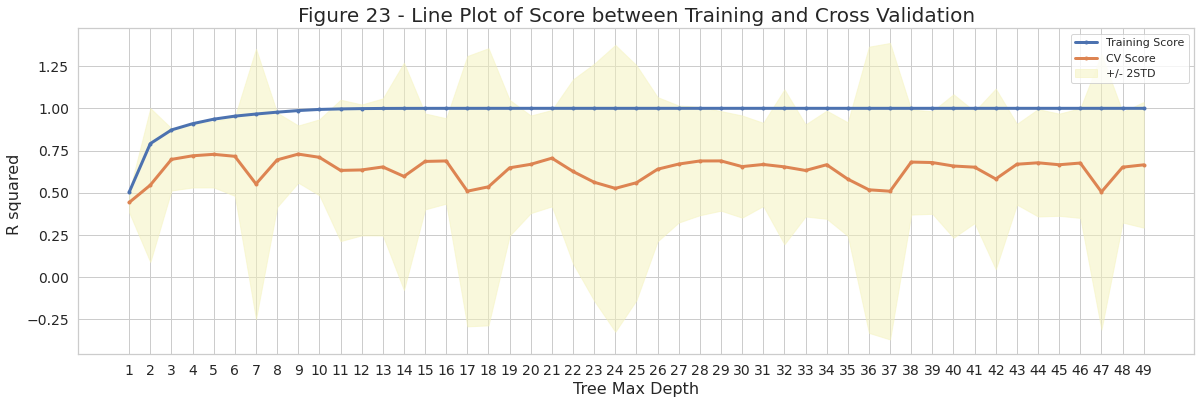

In [384]:
# Intializing subplots
fig, ax = plt.subplots(figsize=(20,6))

# Graphing
ax.plot(depths, train_scores_H, '.-', label='Training Score', lw=3)
ax.plot(depths, cvmeans_H, '.-', label='CV Score', lw=3)
plt.fill_between(depths, cvmeans_H+2*cvstds_H, cvmeans_H-2*cvstds_H, color='#F5F3BB', alpha=0.5, label="+/- 2STD")

# Set ticks and labels
ax.set_xticks(depths)
ax.set_xlabel("Tree Max Depth", fontsize=16)
ax.set_ylabel("R squared ", fontsize=16) 
ax.tick_params(labelsize=14)

# Setting legend
ax.legend()

# Setting title
ax.set_title("Figure 23 - Line Plot of Score between Training and Cross Validation", fontsize=20)
plt.show()

Figure 23 - Line Plot of Score between Training and Cross Validation

In [385]:
# Finding best cvmean score
best_cv_H = max(cvmeans_H)

# Finding best depth
best_depth_H = list(cvmeans_H).index(max(cvmeans_H)) +1 

print(f"The best cv score is {best_cv_H}. The best depth is {best_depth_H}.")
print(f"The corresponding training score is {train_scores_H[2]}")

The best cv score is 0.7290580713376716. The best depth is 9.
The corresponding training score is 0.8720392816100598


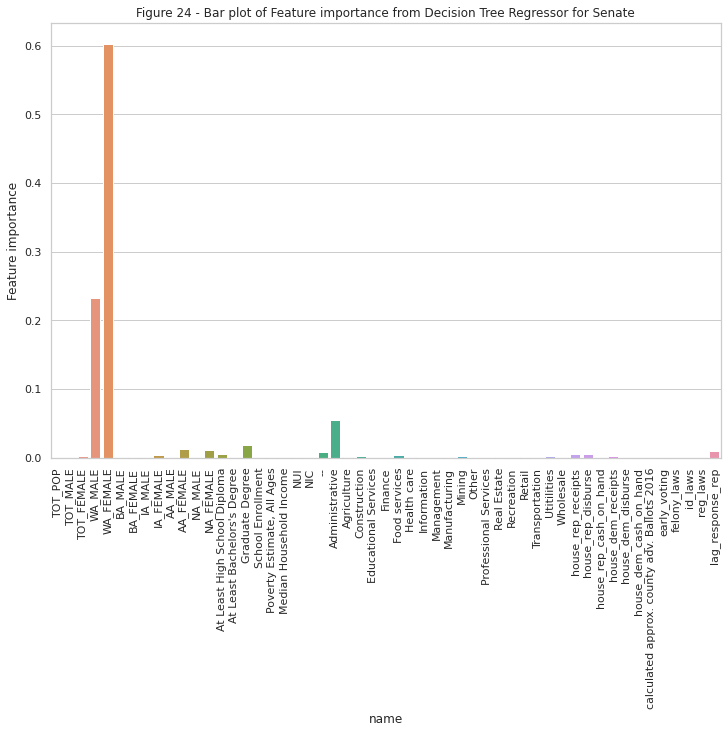

In [386]:
# Feature importance 
# Running decison tree using best_depth to visualize feature importance 
dtree = DecisionTreeRegressor(max_depth=best_depth_H).fit(X_train_H_s, y_train_H)
feature=pd.DataFrame(dtree.feature_importances_)
feature=feature.copy()
feature['name']=house_training_select.columns

# Initializing the subplots
plt.figure(figsize=(12,8))

# Plotting
ax = sns.barplot(x="name", y=0, data=feature)
ax.set_ylabel("Feature importance")
ax.set_title("Figure 24 - Bar plot of Feature importance from Decision Tree Regressor for Senate")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

Figure 24 - Bar plot of Feature importance from Decision Tree Regressor for Senate

#### RidgeCV Base Model (Republican Votes)

In [387]:
#### Ridge regression approach 
ridgecv_H=RidgeCV(cv=3)
ridgecv_H.fit(X_train_H_s,y_train_H)
score_H=ridgecv_H.score(X_train_H_s,y_train_H)
cv_best_H=ridgecv_H.best_score_
print(f"Ridge regression R squared for training set all parameters is {score_H:.4f}")
print(f"Ridge regression R squared for validation all parameters is {cv_best_H:.4f}")

Ridge regression R squared for training set all parameters is 0.9399
Ridge regression R squared for validation all parameters is 0.8564


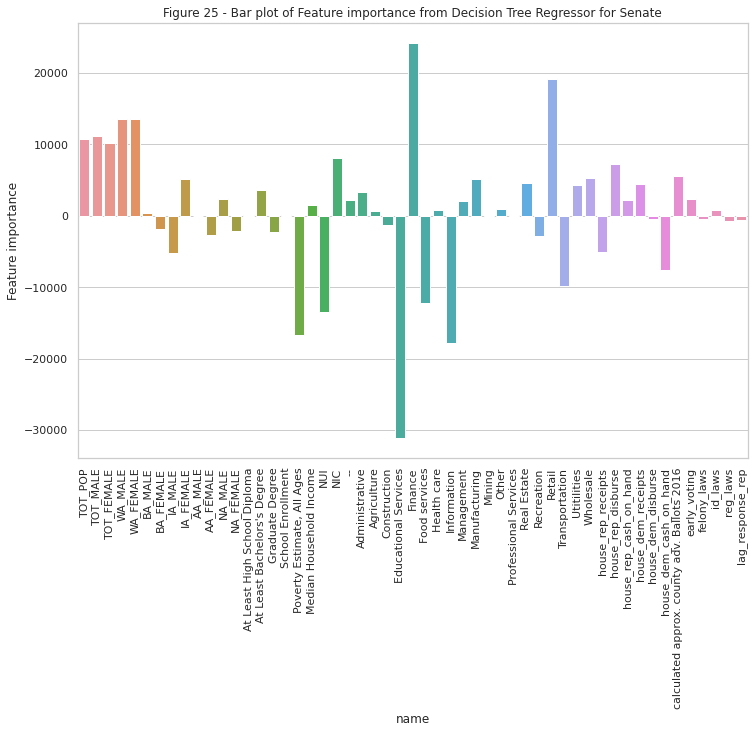

In [388]:
# Visualizing feature importance 
# Creating dataframe
ridge_feature=pd.DataFrame(ridgecv_H.coef_)
ridge_feature=ridge_feature.copy()
ridge_feature['name']=house_training_select.columns

# Intializing the subplot
plt.figure(figsize=(12,8))

# Graphing 
ax = sns.barplot(x="name", y=0, data=ridge_feature)
ax.set_ylabel("Feature importance")
ax.set_title("Figure 25 - Bar plot of Feature importance from Decision Tree Regressor for Senate")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

### Comparisons Between the Different Models

In [389]:
train_scores3 = [train_scores_H[2], score_H]

val_scores3 = [best_cv_H, cv_best_H]

titles3 = ['Decision Tree Regressor', 
            'Ridge Regression']

df_results3 = pd.DataFrame()
df_results3['Model'] = titles3
df_results3['Training Accuracy'] = train_scores3
df_results3['Validation Accuracy'] = val_scores3

display(df_results3)

Model  Training Accuracy  Validation Accuracy
0  Decision Tree Regressor           0.872039             0.729058
1         Ridge Regression           0.939896             0.856421

In [390]:
##### Final prediction for House: 
## 1) aggregate by state 
## 2) devide by state population = proportion of votes to republicans
## 3) Times the seats apportioned for each state 
## 4) aggregate numbers of seats for final prediction 
